# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, PercentFormatter

plt.style.use('ggplot')

TITLE_SIZE = 22
TITLE_PADDING = 10

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }
plt.rcParams.update(params)

import pandas as pd
pd.options.display.max_rows = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import umap

import copy
import os
import time
from tabulate import tabulate
from tqdm.notebook import tqdm

# EDA – *Costa Rican Household Poverty Level Prediction*

# 1) Introduction
---

**Costa Rica** – which ironically for this data competition translates to *Rich Coast* – is a particularly beautiful country in Central America. It has coasts to the Pacific ocean as well as to the Caribbean Sea. Nicaragua borders to the north and Panama to the southeast.

- The country is a **stable democracy with a population of around 5 million in a land area of 51k square kilometers** (Switzerland has around 8.5 million people on 41k sq/km). 
- Costa Rica **ranks fifth in the Human Development Index (HDI) in Latin America**. It **ranks well too in regard to the state of democracy and press freedom**. 
- According to World Happiness Report **Costa Rica is the 12th happiest country in the world**. 
- **The country is considered [a success story in terms of development](https://www.worldbank.org/en/country/costarica/overview)**. It counts as an upper middle-income country and had a steady economic growth over the past 25 years. 
- Costa Rica's economy mainly dependended on agriculture but has diversified to finance, corporate services for foreign companies, pharmaceuticals and ecotourism. 
- Due to its political stability, social contract and steady growth Costa Rica has achieved [one of the lowest poverty rates in Latin America and the Caribbean](https://www.worldbank.org/en/country/costarica/overview).

## Context of the data competition
- **Costa Rica maintains a comprehensive welfare program** for their citizens in need – though right now this is [very much challenged due to COVID-19](https://www.developmentaid.org/#!/news-stream/post/77842/poverty-in-costa-rica-has-reached-the-highest-level-for-30-years). 
- To properly function **welfare programs have to precisely find the right people to give to**. This **can be challenging for the poorest** because they often can’t provide income and expense records to prove qualification for welfare.
- One algorithm to verify income qualification that is used in Latin America is the **«Proxy Means Test» (PMT)**. With this algorithm welfare agencies consider household attributes like the material of their walls and ceiling or the assets found in the home to classify them and predict the level of need. 
- To improve the algorithm the [Inter-American Development Bank IDB](https://www.iadb.org/en) (the largest source of development financing for Latin America & Caribbean) has [launched a Kaggle competition in 2018](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/overview). The aim of the competition was to gain new insights in order to improve PMT’s performance.

## Competition task
The task in this competition is to identify which households have the highest need for social welfare assistance. More precisely **we have to predict one out of four income levels** which **makes this a multiclass classification problem**: 

- `1` -> extreme poverty
- `2` -> moderate poverty
- `3` -> vulnerable households
- `4` -> non vulnerable households

## The data set
From the file description of the data set we gather:
- One row represents one person in the data.
- Multiple people can be part of a single household.
- Features relate to the household (e.g. quality of housing) as well as to indidividual demographics (age, sex, education etc.).

## Core data fields
- `Id` - a unique identifier for each row.
- `Target` - the target is an ordinal variable indicating the four groups of income levels.
- `idhogar` - a unique identifier for each household. This can be used to create household-wide features. All rows in a given household will have a matching value for this identifier.
- `parentesco1` - indicates if this person is the head of the household.

## Metric and scoring
- The **model quality is evaluated based on the macro F1 score**. 
- The [F1 score is a weighted average of precision and recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). Its best value is at 1 and its worst at 0. 
- The relative contribution of precision and recall to the F1 score are equal. 
- **The F1 *macro* does not take label imbalance into account**. 
- We'll see in the EDA that **we have a substantially imbalanced class distribution so this metric at first glance seems somewhat counterintuitive.** At the same time we can argue that our model is supposed to equally work well for all classes regardless of the class distribution and that dealing with the imbalance in the given data simply is our problem to deal with. 

**Important: Only the heads of households are used in scoring**. 
- All household members are included in the data, but only predictions for the heads count towards the score. 
- That means too that **we have to be careful not to introduce data leakage in crossvalidation. We have to split samples in such way that no households both are in the train and validation split of a fold.** 
- Another option we can look into is to aggregate the data to the level of households and train/predict from that.

## Good to know
- Participants in the competition could [submit a maximum of 5 entries per day](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/rules) on Kaggle. Since the competition officially ended we can submit as many entries as we'd like.
- The [final top score is 0.44878](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/leaderboard).

## What we do not know
Unfortunately we do not know in which way the PMT was used or assessed for the given data set. 
- Did the welfare workers already knew wich households were in need and collected data afterwards in order to more precisely explore their poverty? Or is it the other way round and did they first collect the data and then derived the qualification?
- In the former case we deal with an effect of actual poverty toward circumstances of living/being. E.g., *«I know very poor households. Now I go to their house and gather as much evidence about their dire living and demographics».* 
- The latter would deal with the relationship between information about households and their inhabitants and the subjective assessment of welfare workers. E.g., *«I received some information about households and from these I make an educated guess which of these might need help»*.

In short: We do not exactly know what we predict here. Do we predict ground truth («actual poverty») from factual circumstances? Or do we predict what a welfare worker has thought about some data he/she received?

# 2) EDA
---

## Loading the data
- As usual the Kaggle competition data consists of a training and a test set. 
- We also get the additional file description `codebook.csv` that provides information about the various features and we get a sample submission file.

**Loading the data and printing the basic stats of the dataframes gets us these insights**:
- The **training data contains 9'557 samples** (aka people).
- **With 23'856 samples we have more than double the amount of test data**.
- We have **142 predicting features** and **one dependent variable named `Target`**.
- **With just ~46MB memory consumption is low**.
- The **features are continuous as well as categorical**.
- Several features already are collected or transformed as one hot encoded categoricals.
- At first glance **just five features seem to have missing values**: `v2a1`, `v18q1`, `rez_esc`, `meaneduc` and `SQBmeaned`

In [2]:
df_train = pd.read_csv("_data/train.csv")
df_test = pd.read_csv("_data/test.csv")
codebook = pd.read_csv("_data/codebook.csv")

df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [3]:
print(f"Training data: {df_train.shape[0]:6,.0f} samples and {df_train.shape[1]:3.0f} features, target included")
print(f"Test data:     {df_test.shape[0]:6,.0f} samples and {df_test.shape[1]:3.0f} features, target not included")

Training data:  9,557 samples and 143 features, target included
Test data:     23,856 samples and 142 features, target not included


In [4]:
display(df.info(memory_usage="deep", verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33413 entries, 0 to 33412
Data columns (total 143 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    Id               33413 non-null  object 
 1    v2a1             9150 non-null   float64
 2    hacdor           33413 non-null  int64  
 3    rooms            33413 non-null  int64  
 4    hacapo           33413 non-null  int64  
 5    v14a             33413 non-null  int64  
 6    refrig           33413 non-null  int64  
 7    v18q             33413 non-null  int64  
 8    v18q1            7945 non-null   float64
 9    r4h1             33413 non-null  int64  
 10   r4h2             33413 non-null  int64  
 11   r4h3             33413 non-null  int64  
 12   r4m1             33413 non-null  int64  
 13   r4m2             33413 non-null  int64  
 14   r4m3             33413 non-null  int64  
 15   r4t1             33413 non-null  int64  
 16   r4t2             33413 non-null  int64

None

In [5]:
display(pd.concat([df.head(3), df.tail(3)]))

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.00,0.0,100.0,1849,4.0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.00,64.0,144.0,4489,4.0
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.25,64.0,121.0,8464,4.0
33410,ID_07dbb4be2,NaN,0,3,0,1,1,0,NaN,0,...,16,144,16,36,4,4.00,1.0,36.0,144,NaN
33411,ID_34d2ed046,NaN,0,3,0,1,1,0,NaN,0,...,25,144,16,36,4,4.00,1.0,36.0,144,NaN
33412,ID_34754556f,NaN,0,3,0,1,1,0,NaN,0,...,36,2601,16,36,4,4.00,1.0,36.0,2601,NaN


In [6]:
# with pd.option_context('display.float_format', '{:,.1f}'.format):
#     display(df.describe().T)

By **looking at the codebook** I notice:
- The **feature columns are mainly in disorder** and do not seem to have any apparent overall structure.
- The **feature explanations are terse**.
- Most of the **features relate to housing, demography, education and geography/region**.
- **29 features are numerical, 104 features are categorical**. 102 of the categoricals are binary, so we do not need to one hot encode the data. 
- **34 features are individual features.** The other **99 features relate to the household and are identical among persons that share the same household**.

In [7]:
# display(codebook)

## Households and heads of households
Since only the predictions for heads of households count toward scoring we should know the respective counts.
- **We have more than double the amount of heads of households in the test data than in the training data**.
- **There are a couple more households than heads of households** in both sets.

In [8]:
heads_in_train = df_train[df_train.parentesco1==True].shape[0]
heads_in_test = df_test[df_test.parentesco1==True].shape[0]

households_in_train = df_train.idhogar.nunique()
households_in_test = df_test.idhogar.nunique()

print(f"Training data: {households_in_train:,.0f} households and {heads_in_train:,.0f} heads of household.")
print(f"Test data:     {households_in_test:,.0f} households and {heads_in_test:,.0f} heads of household.")

Training data: 2,988 households and 2,973 heads of household.
Test data:     7,352 households and 7,334 heads of household.


We should also validate that every household only has one target label.

- We notice that **most of the households are qualified in only one class**, which makes sense. Why should one household have different target classes?
- **However, 84 households have two class labels** (as per their inhabitants) and **one household («5c6f32bbc») even has 3. This doesn't make sense and I suspect that this is due to erroneuous data collection.** 
- If we wanted to aggregate on household level we either have to clean these duplicate qualifications or aggregate on the level of the head of household. The latter would be closer to the competition description (*«head of household counts toward scoring»*).

In [9]:
print("Value counts for unique target labels in households")
display(df_train.groupby("idhogar").Target.nunique().value_counts())

Value counts for unique target labels in households


1    2903
2      84
3       1
Name: Target, dtype: int64

In [10]:
print("Household «5c6f32bbc» has three class labels.")
cols = ["Id", "idhogar", "parentesco1", "Target"]
display(df_train[cols][df_train.idhogar=="5c6f32bbc"].T)

Household «5c6f32bbc» has three class labels.


,6023,6024,6025
Id,ID_31efaae60,ID_d46abdcca,ID_d60f45637
idhogar,5c6f32bbc,5c6f32bbc,5c6f32bbc
parentesco1,1,0,0
Target,3,4,2


**Are there households with more than one head of household? No there aren't.** But we have the opposite of 33 households without a head of household (as we already found out above).

In [11]:
print("Value counts for heads of households")
display(df.groupby("idhogar").parentesco1.sum().value_counts())

Value counts for heads of households


1    10307
0       33
Name: parentesco1, dtype: int64

Two more **sanity checks**...

- **Do we have households that are in both data sets? No, we don't.**
- **Do we have individuals that are in both data sets? That isn't the case neither.**

In [12]:
train_households = set(df_train.idhogar.unique())
test_households = set(df_test.idhogar.unique())
joint_households = len(set.intersection(train_households, test_households))
print(f"There are {joint_households} households that are in both data sets.")
print("And a value count for unique Ids confirms that all Ids are unique.")
display(df.Id.value_counts().value_counts())

There are 0 households that are in both data sets.
And a value count for unique Ids confirms that all Ids are unique.


1    33413
Name: Id, dtype: int64

## Redundant samples
The PMT and resulting welfare services very likely refer to household/head of household. The Kaggle competition does assume this anyway. **Do the data samples of the other members of a household contribute any additional information that help to more precisely assess the households need?**

Looking at the individual demographic features I gather that these will contribute towards prediction but very likely can be aggregated. For example we can add up years of schooling of all household members or take the average and standard deviation of age.

**The 34 individual demographic features are these:**

    escolari          years of schooling
    rez_esc           Years behind in school
    dis               =1 if disable person
    male              =1 if male
    female            =1 if female
    age               Age in years

    estadocivil1      =1 if less than 10 years old
    estadocivil2      =1 if free or coupled uunion
    estadocivil3      =1 if married
    estadocivil4      =1 if divorced
    estadocivil5      =1 if separated
    estadocivil6      =1 if widow/er
    estadocivil7      =1 if single
    parentesco1       =1 if household head
    parentesco2       =1 if spouse/partner
    parentesco3       =1 if son/doughter
    parentesco4       =1 if stepson/doughter
    parentesco5       =1 if son/doughter in law
    parentesco6       =1 if grandson/doughter
    parentesco7       =1 if mother/father
    parentesco8       =1 if father/mother in law
    parentesco9       =1 if brother/sister
    parentesco10      =1 if brother/sister in law
    parentesco11      =1 if other family member
    parentesco12      =1 if other non family member

    instlevel1        =1 no level of education
    instlevel2        =1 incomplete primary
    instlevel3        =1 complete primary
    instlevel4        =1 incomplete academic secondary level
    instlevel5        =1 complete academic secondary level
    instlevel6        =1 incomplete technical secondary level
    instlevel7        =1 complete technical secondary level
    instlevel8        =1 undergraduate and higher education
    instlevel9        =1 postgraduate higher education

## Redundant features
From the codebook we also see that the last 9 features are squares of other features in the data set (`SQBescolari` to `agesq`). 
- These derivatives do not seem to carry any additional information and can be removed.
- To make sure the squared features indeed are redundant I compare the values of the base features and their derivatives.

In [13]:
# Checking if base features are identical to their squared derivates
base_features = ['escolari', 'age', 'hogar_total', 'edjefe', 
                 'hogar_nin', 'overcrowding', 'dependency', 
                 'meaneduc', 'age']

derivative_features = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 
                       'SQBmeaned', 'agesq']

for base, derivative in zip(base_features, derivative_features):
    try:
        if np.array_equal(np.square(df[base]).values, df[derivative].values)==True:
            print(f"{base}: OK")
    except:
        print(f"{base}: NOT identical")    

escolari: OK
age: OK
hogar_total: OK
edjefe: NOT identical
hogar_nin: OK
dependency: NOT identical
age: OK


Why do `dependency` and `edjefe` yield an error in the loop? 
- Both features are numerical but contain `yes` and `no` as values as well. 
- Nonetheless their derivatives are redundant, because the squares simply are based on value 1 and 0 for yes/no.

In [14]:
display(df.edjefe.value_counts().sort_index(ascending=False)[:4])
print()
display(df.edjefe.value_counts().sort_index(ascending=False)[:4])

yes      416
no     12818
9       1564
8       1020
Name: edjefe, dtype: int64

yes      416
no     12818
9       1564
8       1020
Name: edjefe, dtype: int64

In addition to the derivates **the features male/female can be reduced to one binary.** These are exact opposites – if I am not male I have to be female.

In [15]:
# Making sure that df.male is the logical inversion of df.female.
assert np.all(np.logical_not(df.male).astype(int) == np.array(df.female))

**Do we have other exact opposites in the categorical data?** Yes – `area1` and `area2` (*rural/urban area*) can be reduced to one binary too.

In [16]:
# Load my manually annotated version of the codebook that has labels for categoricals.
cb = pd.read_excel("_data/codebook_cleaned.xlsx")
categoricals = cb[cb.cat==1].name

print("These features are exact opposites:")

for cat in categoricals:
    for cat_to_compare in categoricals:
        if np.all(np.logical_not(df[cat]).astype(int) == np.array(df[cat_to_compare])):
            print("- ", cat, cat_to_compare)

These features are exact opposites:
-  area1 area2
-  area2 area1
-  female male
-  male female


## Missing values
- **Three features have a substantial amount of missing values**.
- The missing values for `meaneduc` seem almost negligible and we very likely can impute these or even remove the respective samples.
- `SQBmeaned` will be removed anyways.

In [17]:
missing = [(c, df[c].isna().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
missing = missing[missing.percentage > 0]
# drop Target because the test data doesn't contain the feature
missing = missing[missing.column_name!="Target"]

display(missing.sort_values("percentage", ascending=False).style
        .format("{:.1f}%", subset=["percentage"])
        .hide_index())

column_name,percentage
rez_esc,82.5%
v18q1,76.2%
v2a1,72.6%
meaneduc,0.1%
SQBmeaned,0.1%


## Duplicates
- **We don't have any exact duplicates** in the data. 
- **However, if we drop the `Id` of the samples we get 163 duplicates**.

In [18]:
print(f"There are {df.drop(['Target'], axis=1).duplicated().sum()} exact duplicates in the data set.")
print(f"There are {df.drop(['Id', 'Target'], axis=1).duplicated(keep=False).sum()} duplicates if we omit feature «Id».")

There are 0 exact duplicates in the data set.
There are 163 duplicates if we omit feature «Id».


**What are the duplicates?**
- By filtering by household(s) I find that **these duplicates have to be same sex twin or triplet children in one household.**
- Printing the data for the 6 duplicate samples in one household («9a906088e») confirms this assumption.
- This is another indication that it is worth a try to aggregate, train and predict on the level of households rather than on individuals.

In [19]:
# keep=False keeps all duplicates in the resulting data frame rather than just the first or last duplicate
dups = df.drop(['Id', 'Target'], axis=1).duplicated(keep=False)
df_dups = df.loc[dups[dups==True].index]
display(df_dups.idhogar.value_counts())

9a906088e    6
6c0e9a90e    4
c8d2f9636    4
d792b04fd    3
322cefd2f    2
92fba7778    2
c26e4d4fd    2
8b14516a6    2
892358866    2
959d8cd03    2
92e3936b5    2
56409e468    2
093a10cae    2
c1bb3420f    2
ef497f72d    2
3f779b140    2
0ab1120bf    2
7f142e92d    2
e65701e74    2
9cddc60a7    2
bb7cd22fb    2
3a4626a73    2
693ee5e2a    2
deabaa615    2
ec6458ca8    2
98154df23    2
dae8811f9    2
cfe9bf6ed    2
266306aed    2
a7544e823    2
36353ab28    2
234fa2f44    2
c9ae68a74    2
42d0e8489    2
80406d19b    2
e85512038    2
230793dc7    2
9e616a9e1    2
866f9682d    2
ef31faf0f    2
47ac7fcb9    2
21bb95df8    2
6cfc66ef3    2
e071f34e4    2
a6af97626    2
9bbf7c6ca    2
3e27db2cd    2
06ca88023    2
b7a0b59d7    2
badaa2ab0    2
efec7e82c    2
9359bab11    2
210424415    2
e29376bc8    2
7f40efdb7    2
2f0b233a1    2
03d27346e    2
a1f8de292    2
5241c2e6f    2
9190ee8ef    2
86f7323a8    2
196a98ee8    2
247916a27    2
697533cae    2
4fcaa49a2    2
81ac85627    2
080a77754 

In [20]:
# # Check household 9a906088e which has 6 duplicated samples
# tmp = df[df.idhogar=="9a906088e"].drop(['Id'], axis=1).duplicated(keep=False)
# tmp = tmp[tmp==True].index
# df.loc[tmp].sort_values(by=["male", "agesq"]).T

## Examining the predicting features
Printing value counts for each feature reveals:
- Features `dependency` and `edjefe`/`edjefa` need cleaning of string yes/no and conversion to numerical type.
- `rez_esc` (*«years behind in school»*) contains one non sensical value of 99.

In [21]:
# # Omitting «Id», «Target» and the redundant derivative features
# for feature in df.columns[1:-10]:
#     print(feature, "|", df[feature].dtype)
#     print(df[feature].value_counts(dropna=False).sort_index())
#     print()

## Distribution of numerical features

- We mostly have discrete numerical features and only very few continuous ones.
- `v2a1` (*monthly rent payment*) has a substantial skew. It might make sense to transform the feature to a more normal distribution (e.g. with box-cox, PowerTransformer).
- The extreme skew of `rez_esc` comes from the one erroneous value that we'll fix.

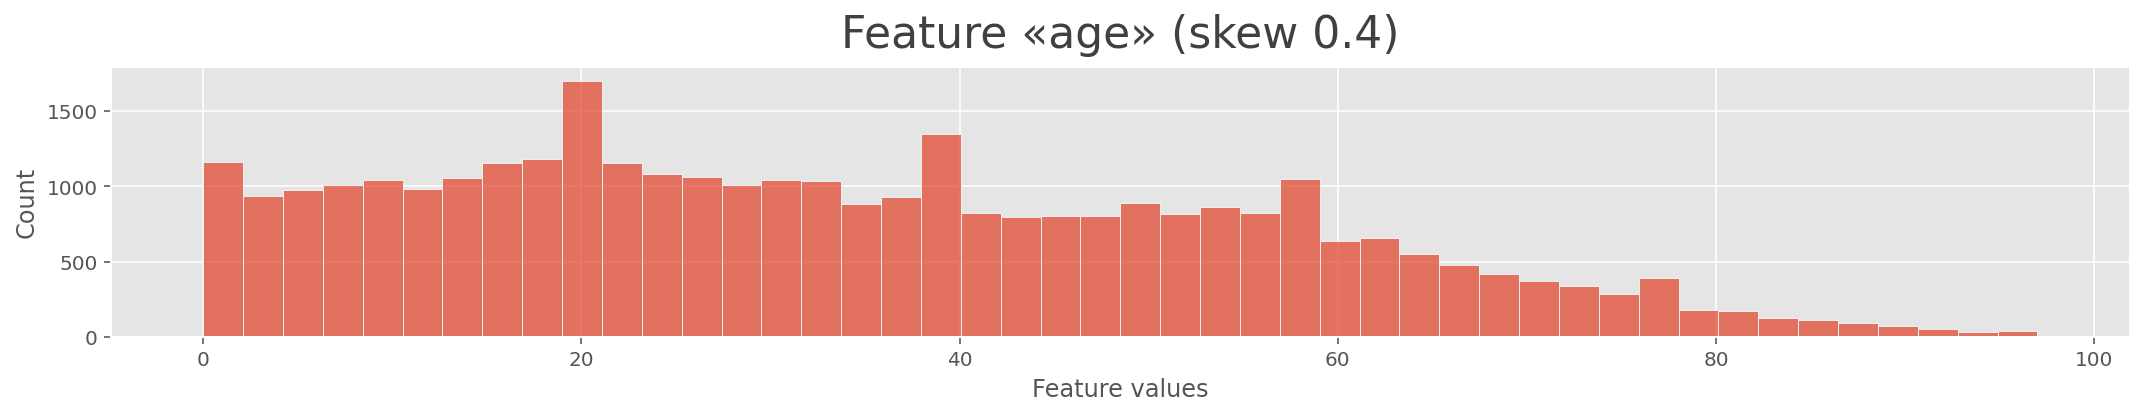

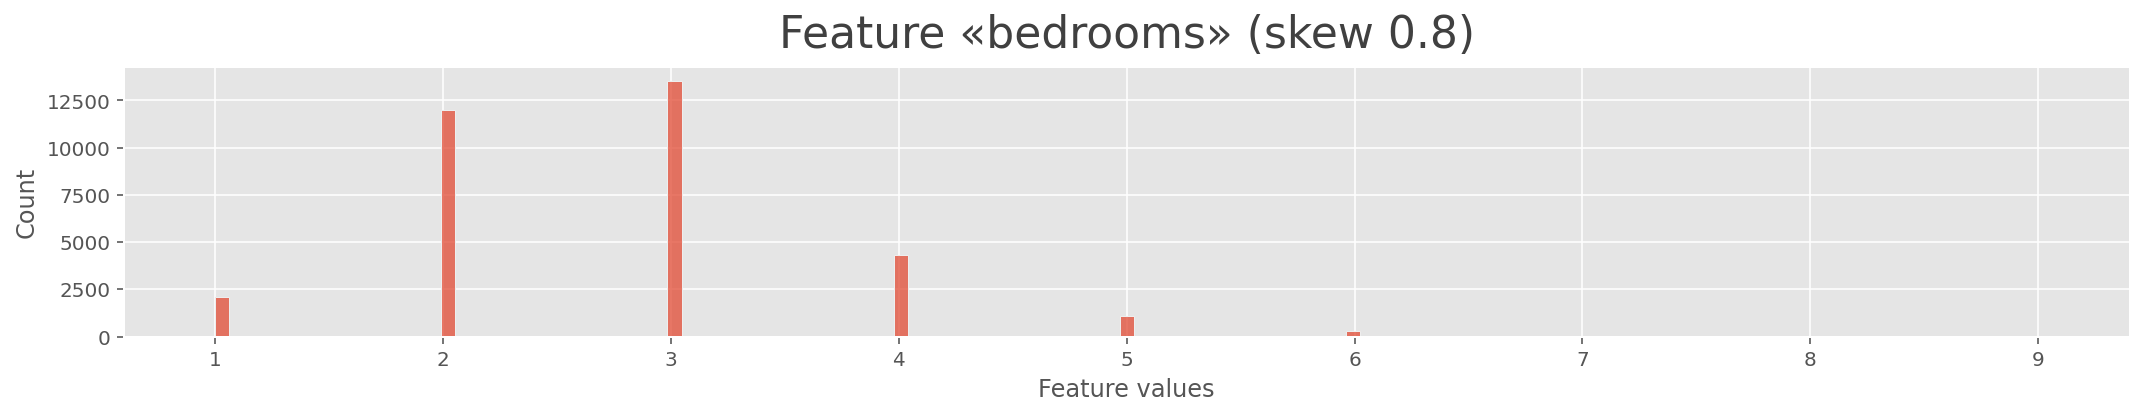

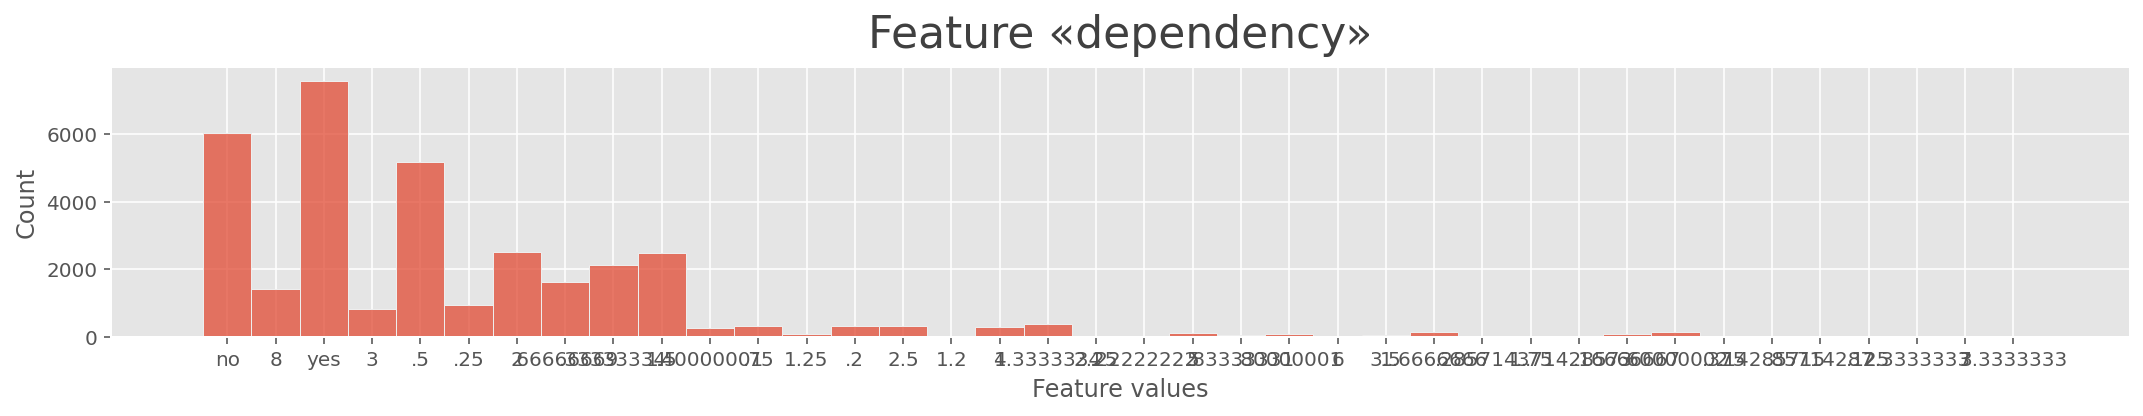

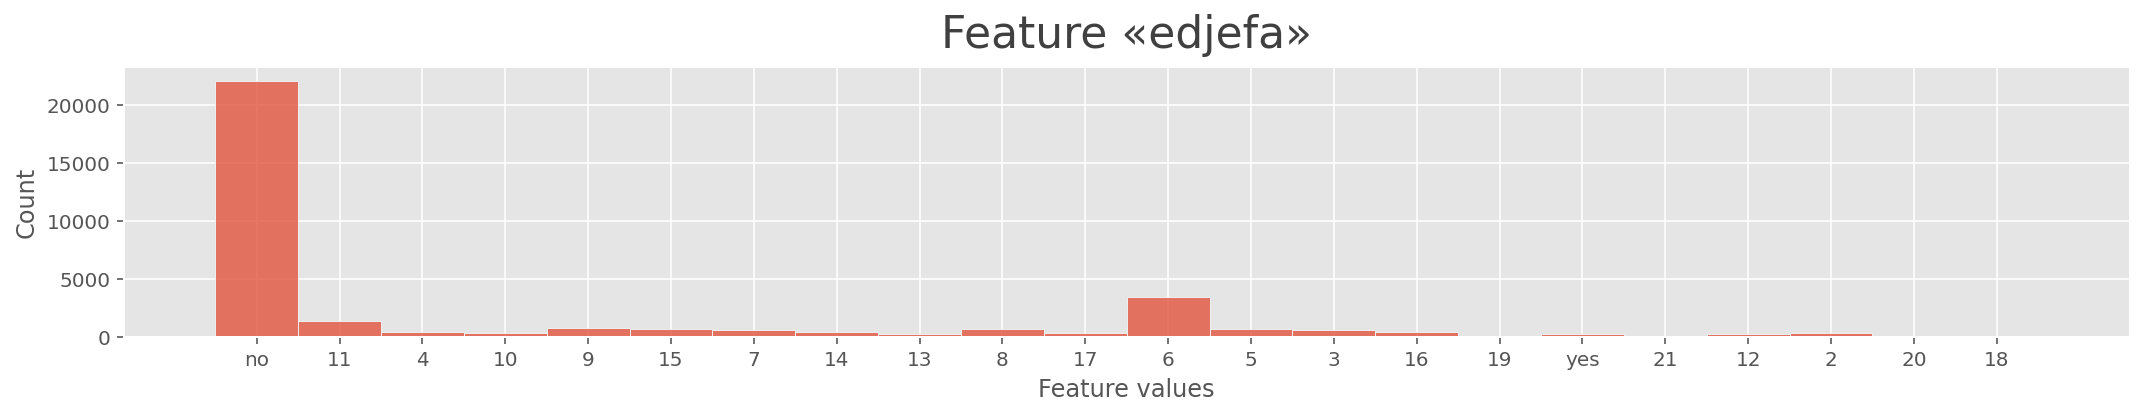

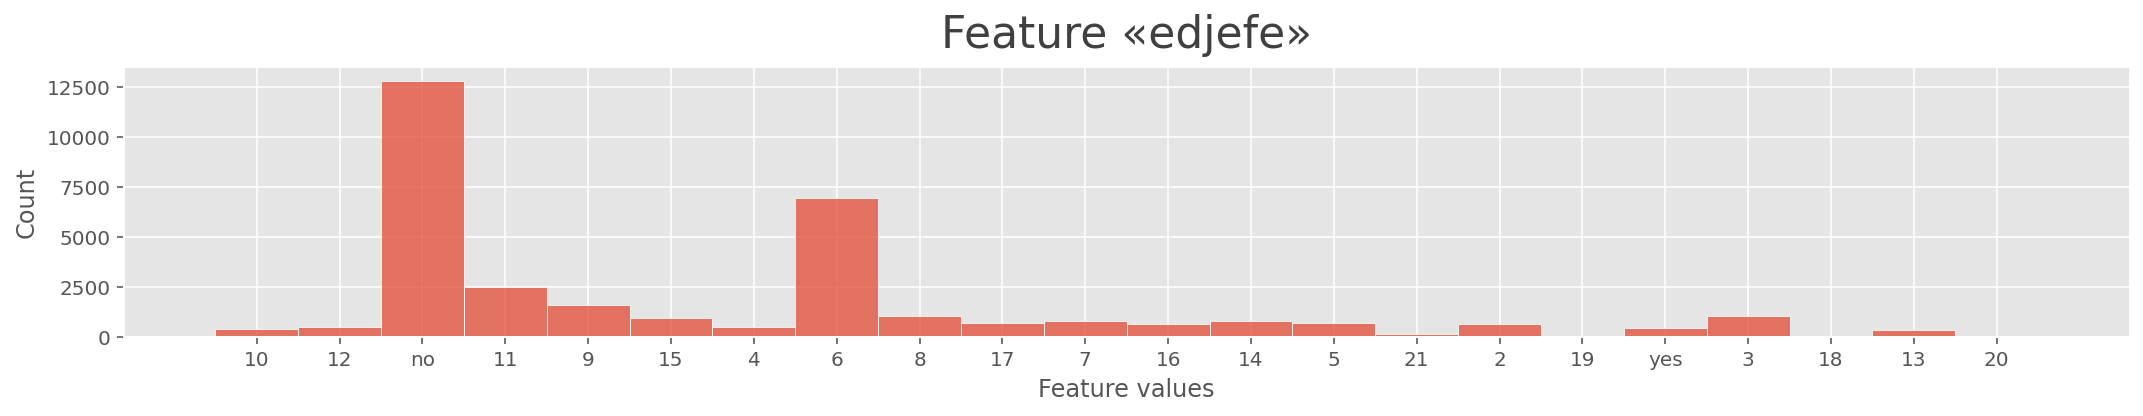

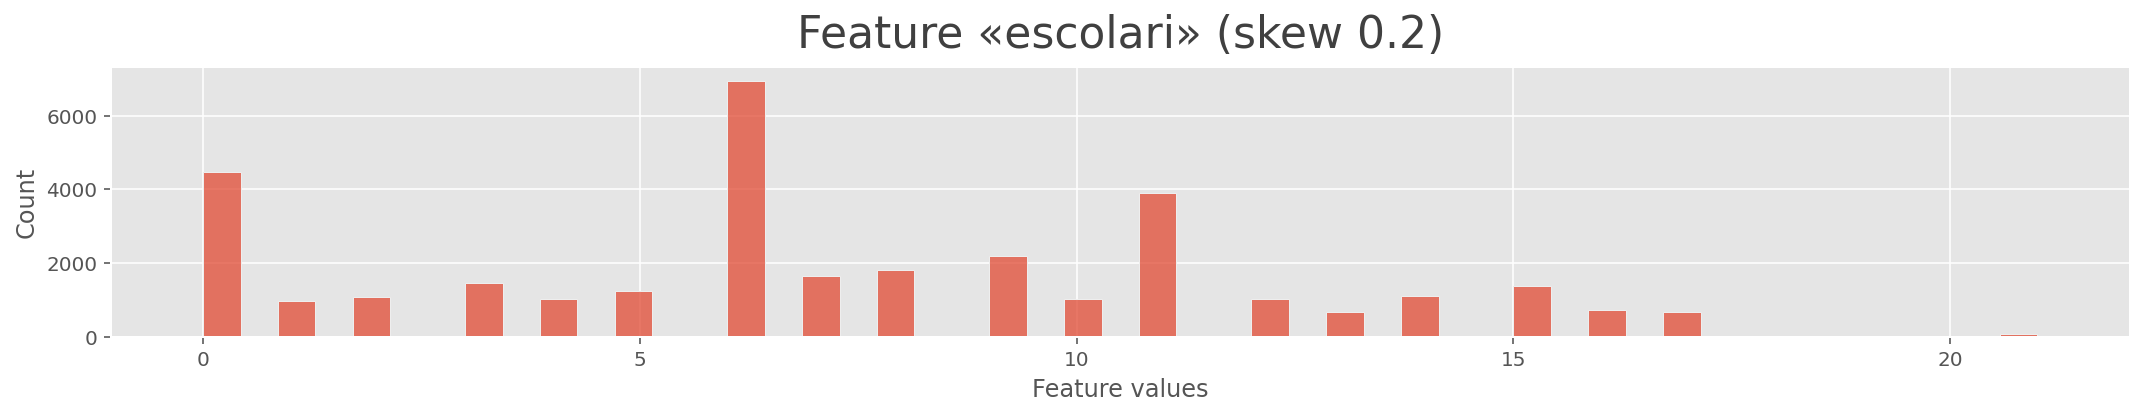

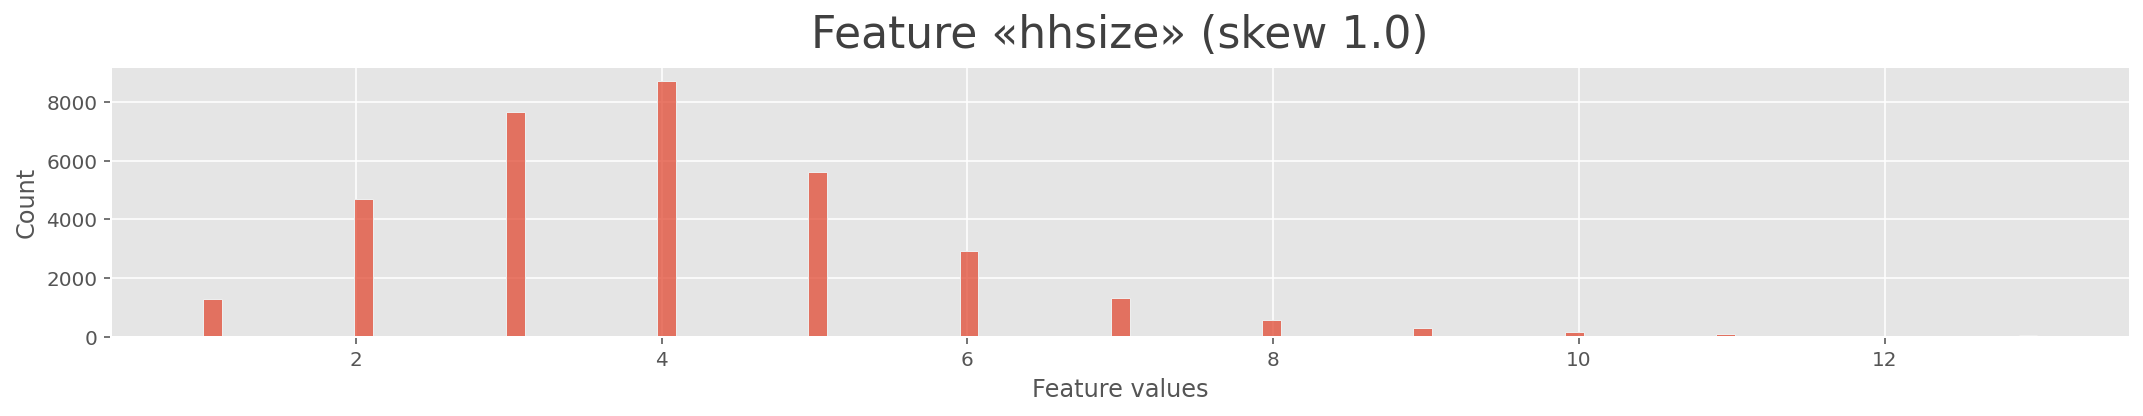

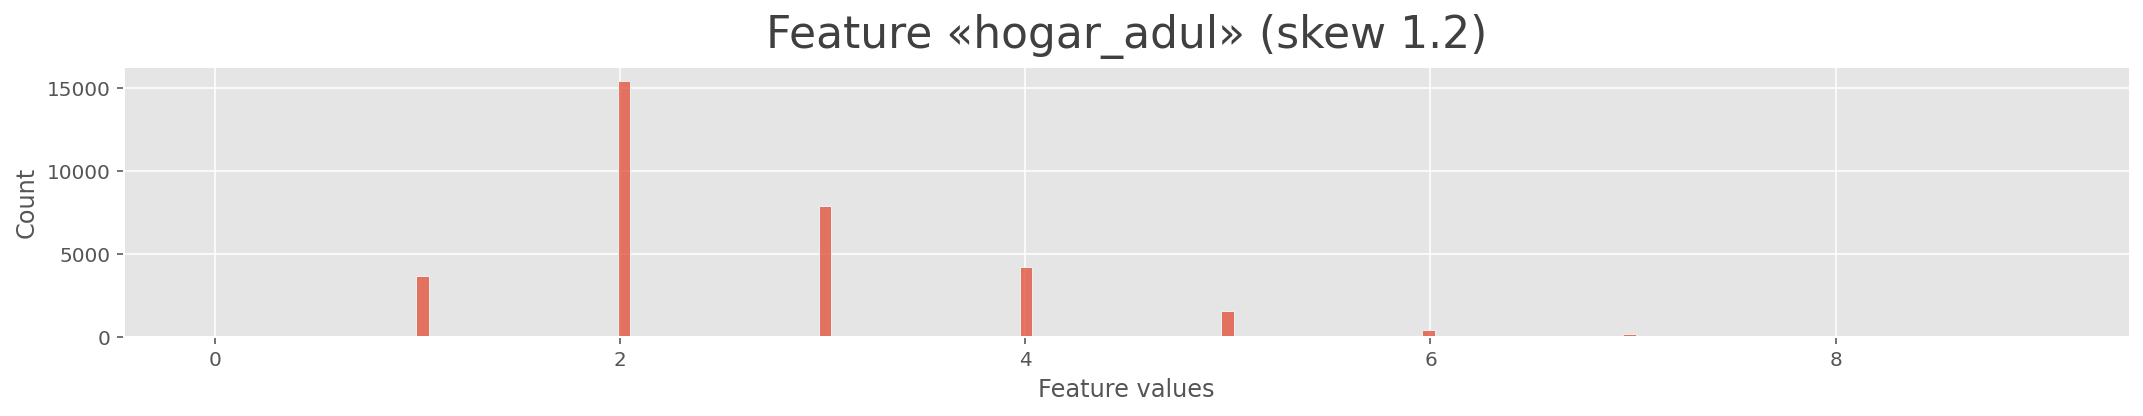

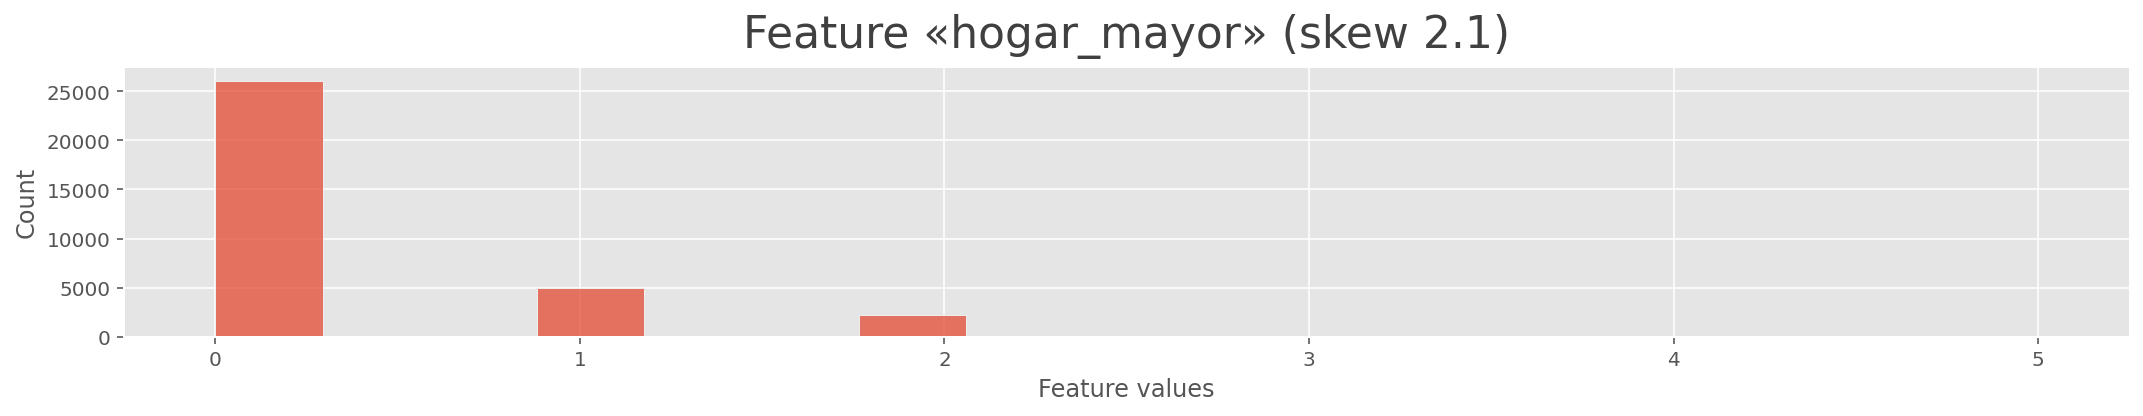

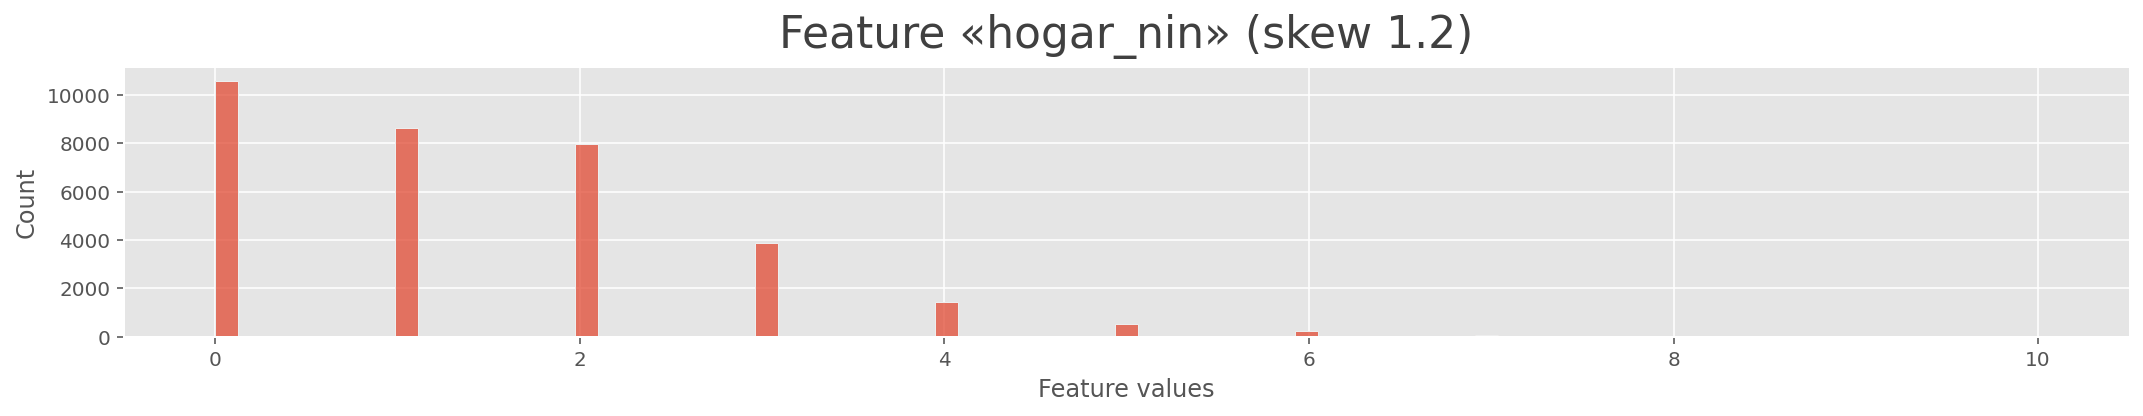

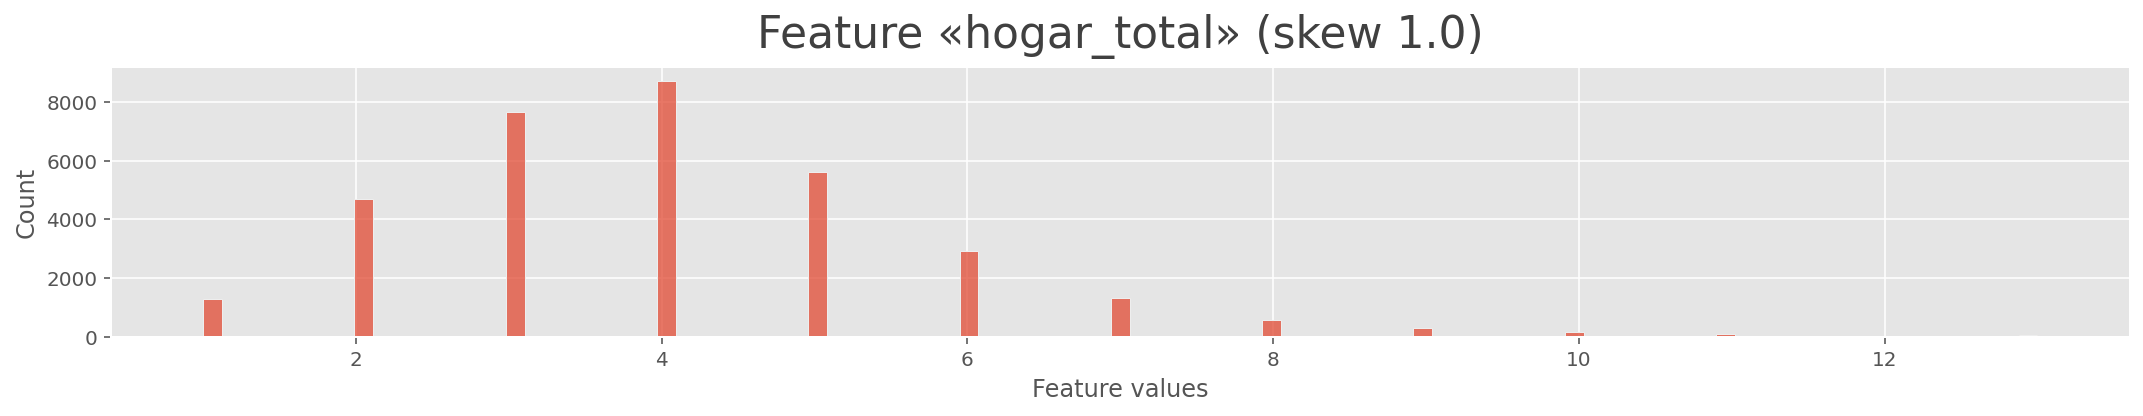

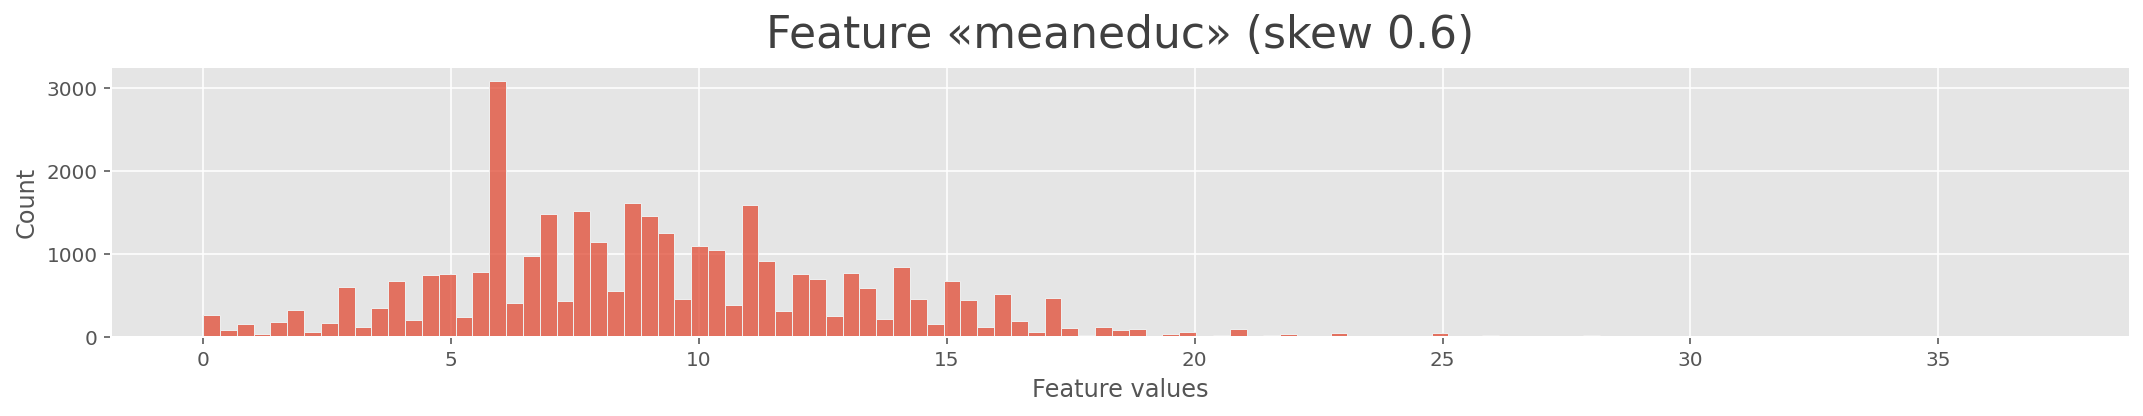

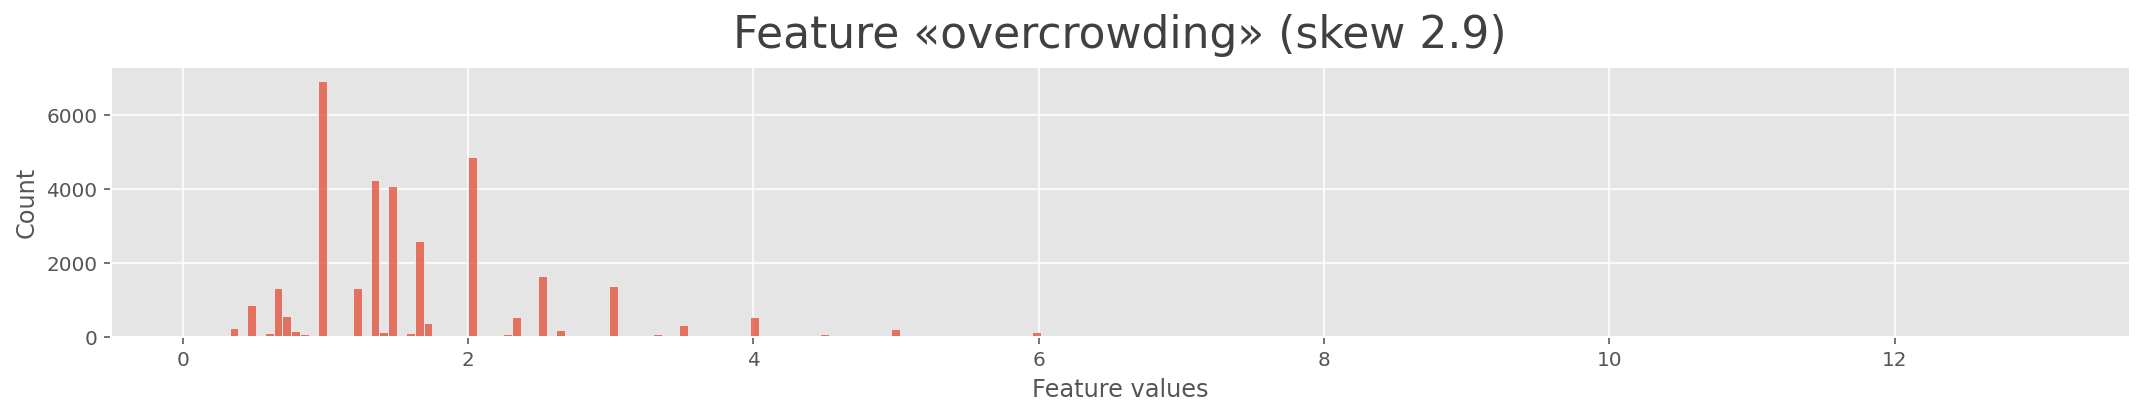

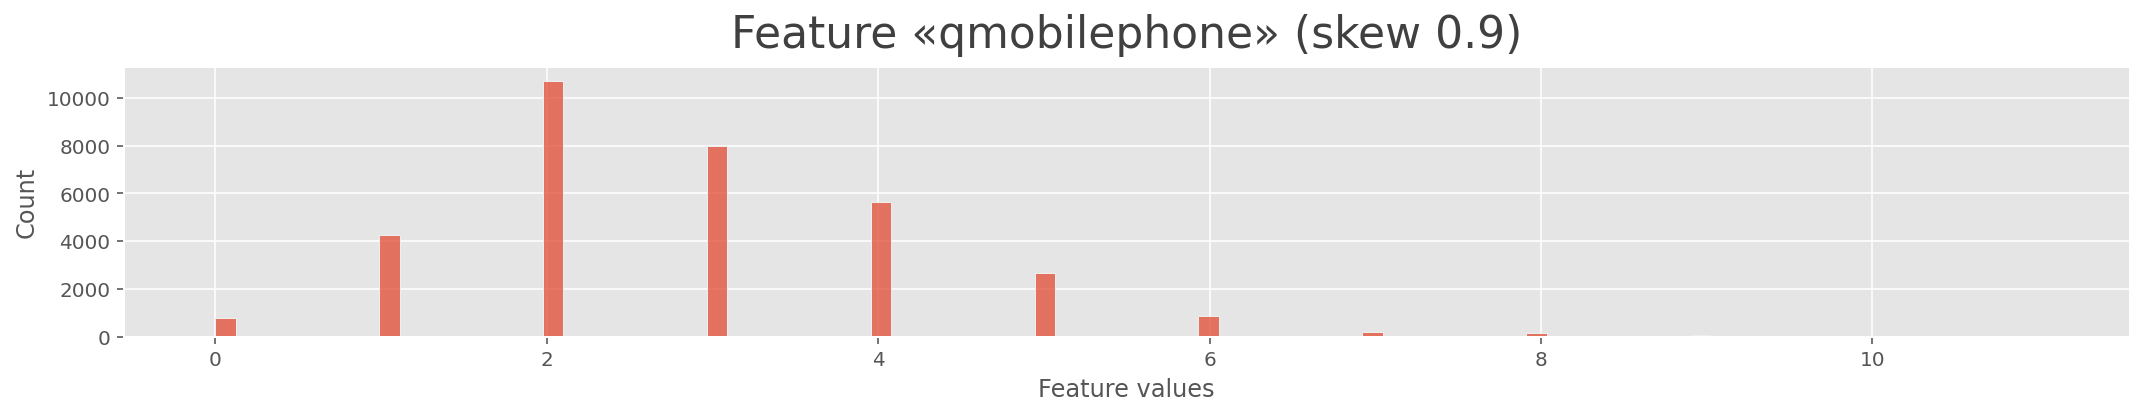

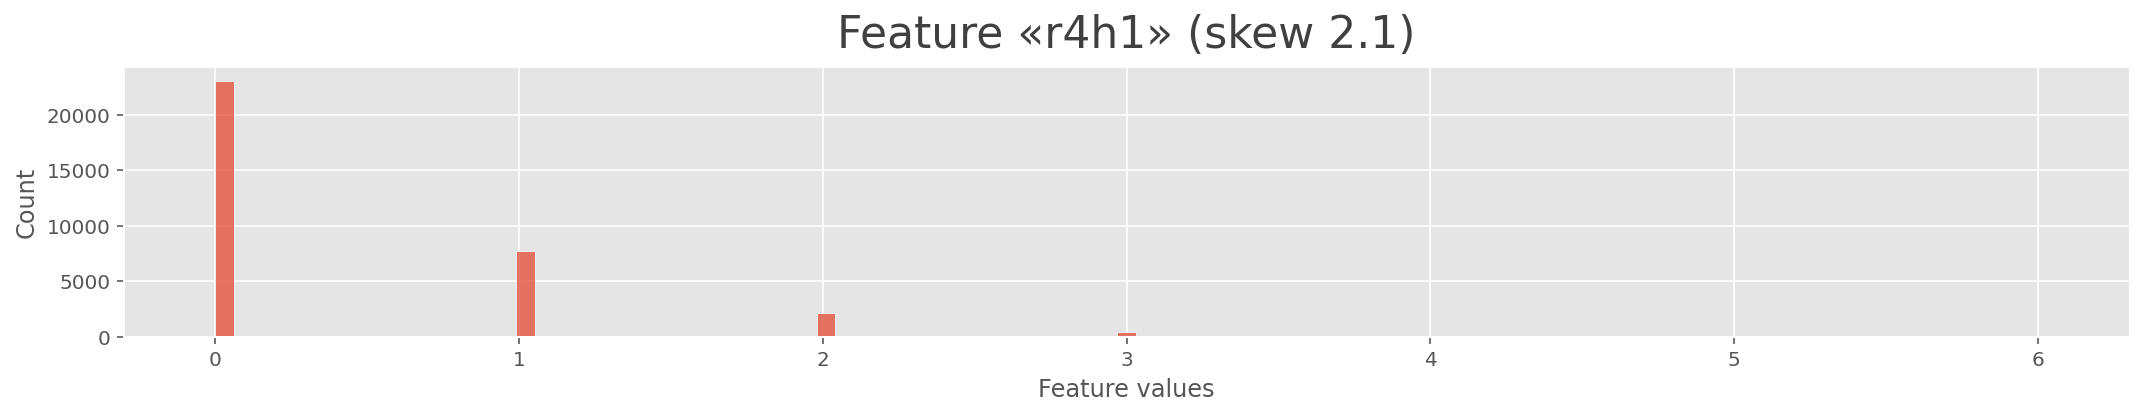

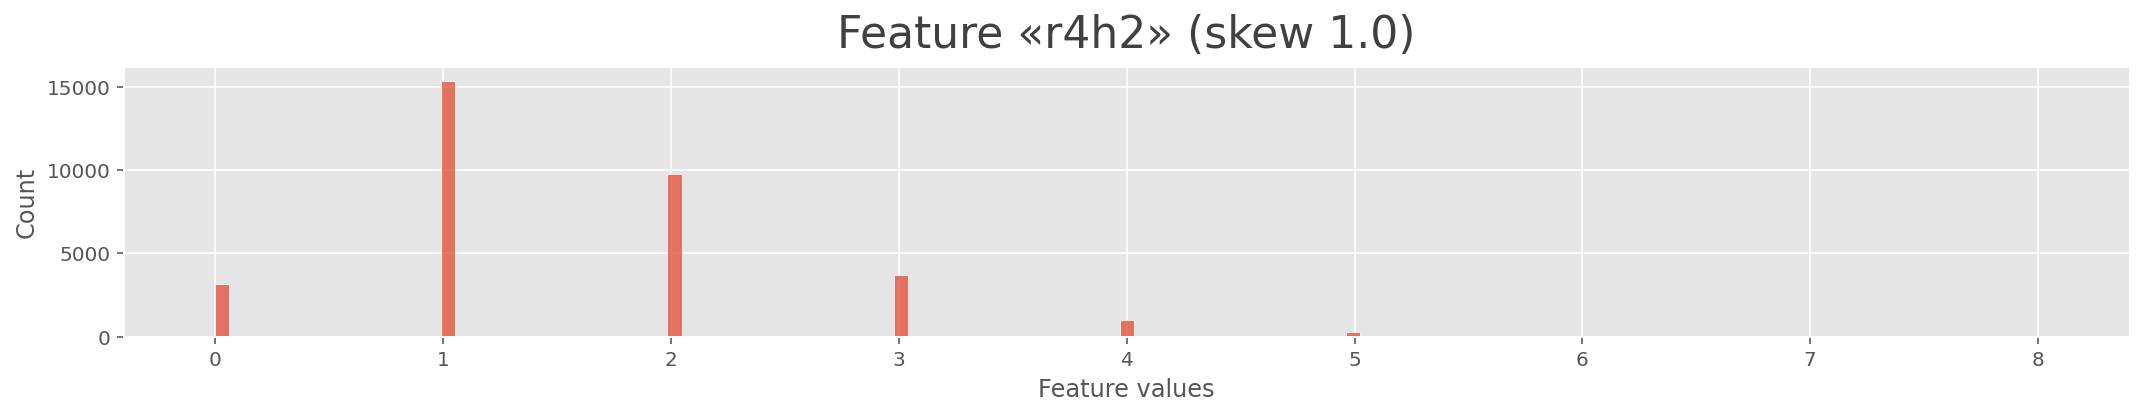

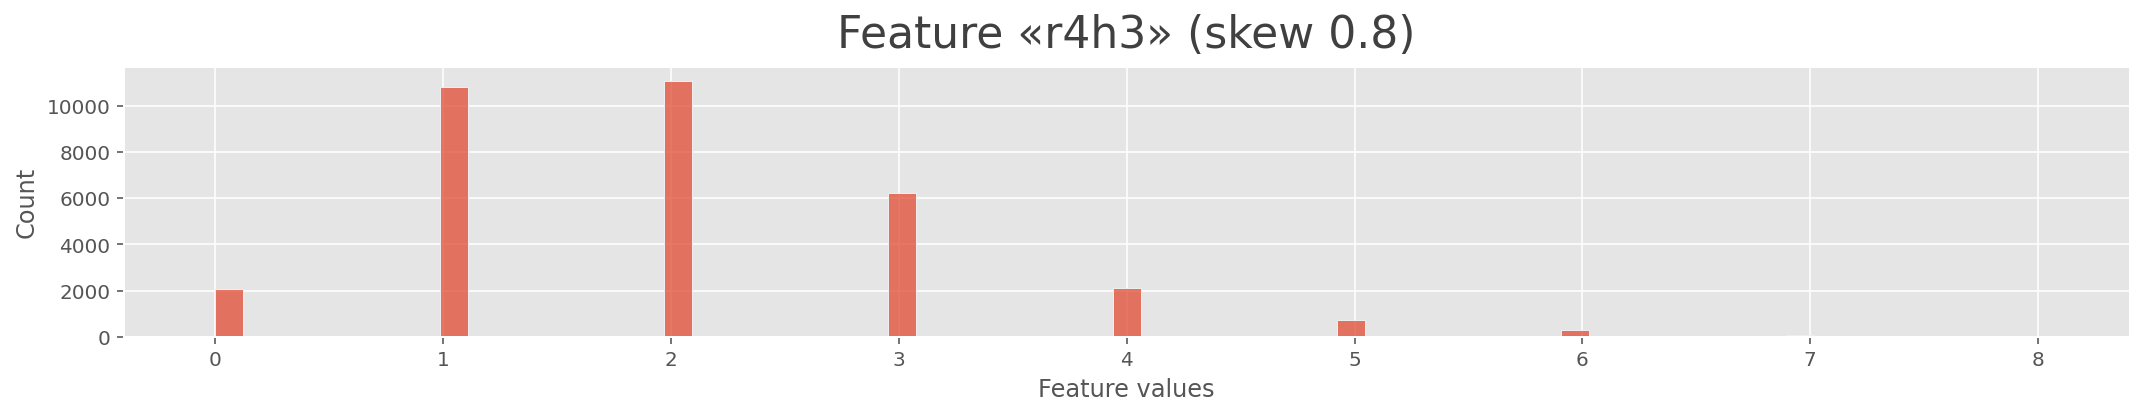

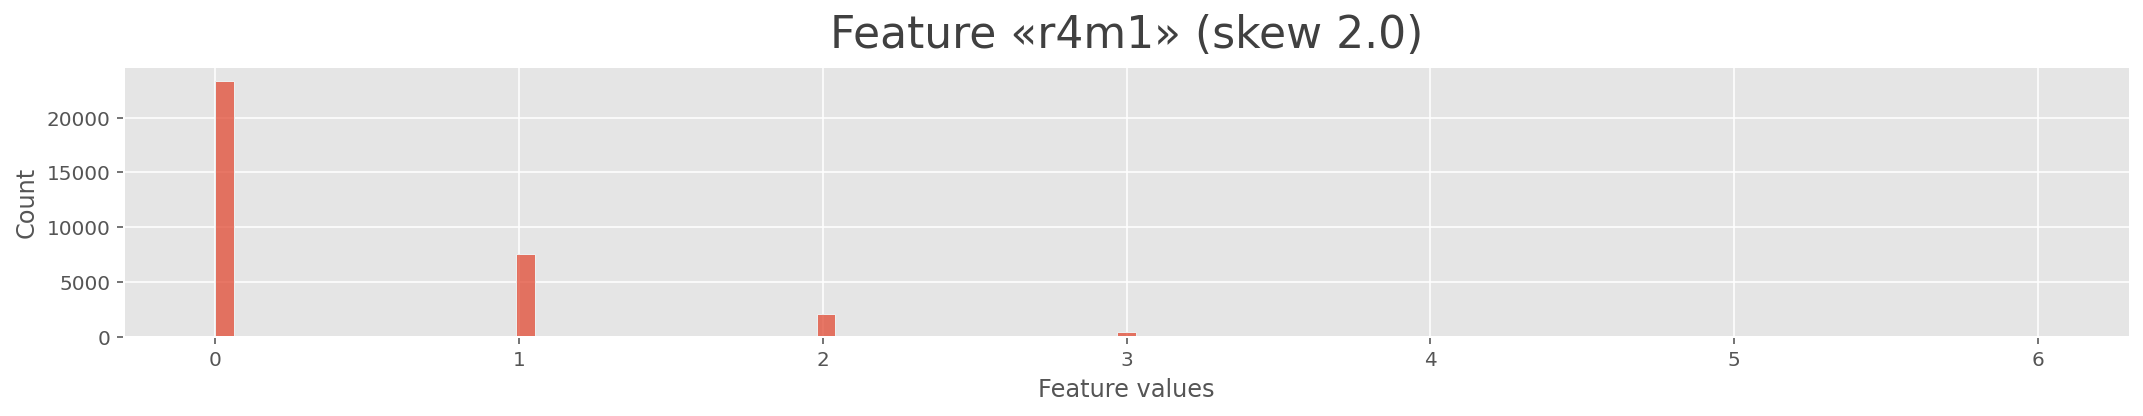

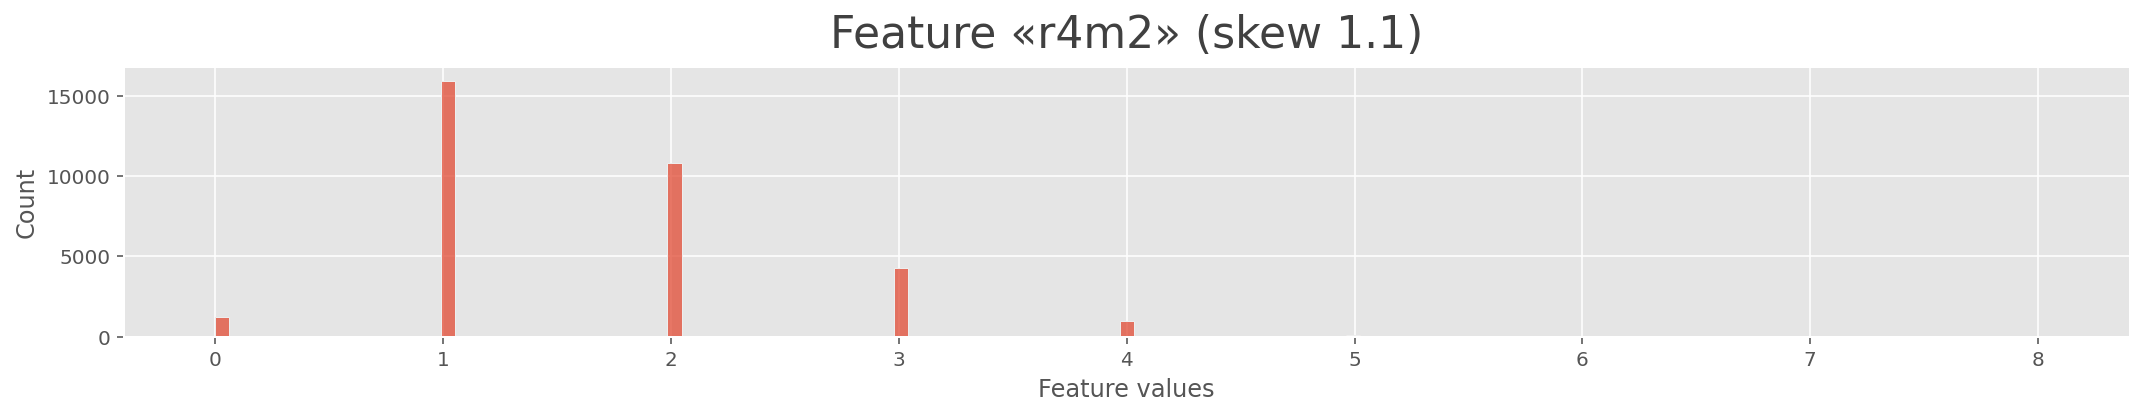

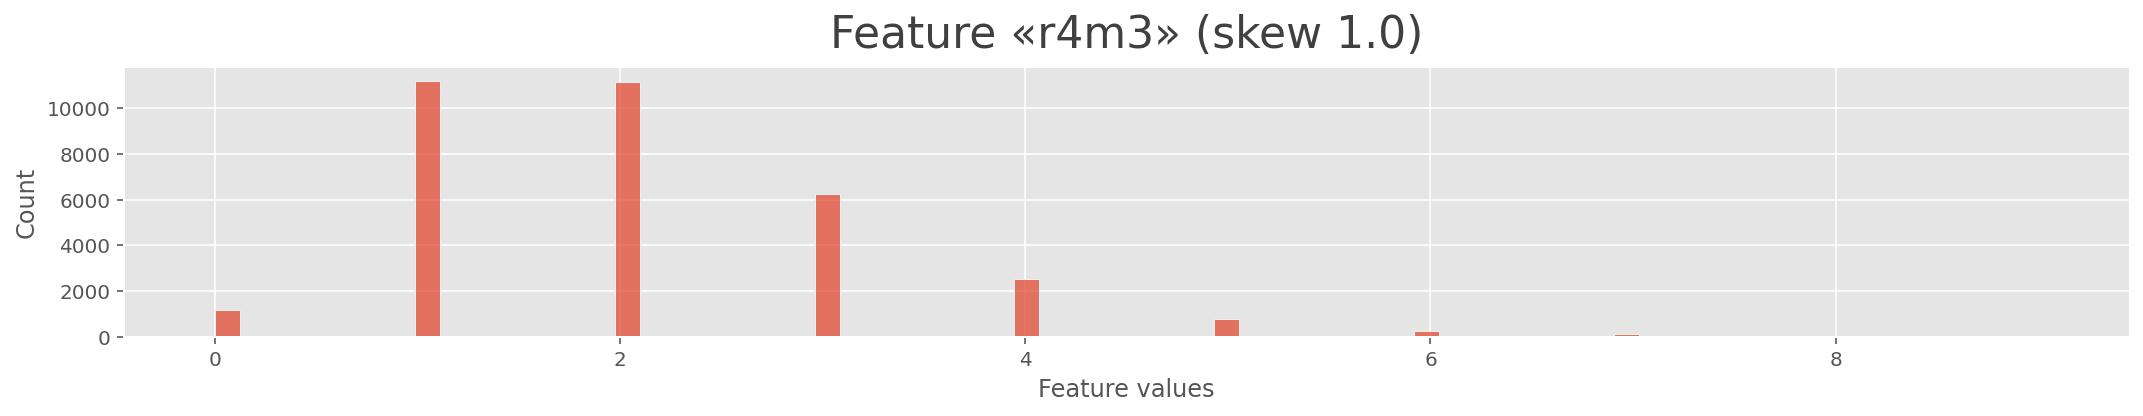

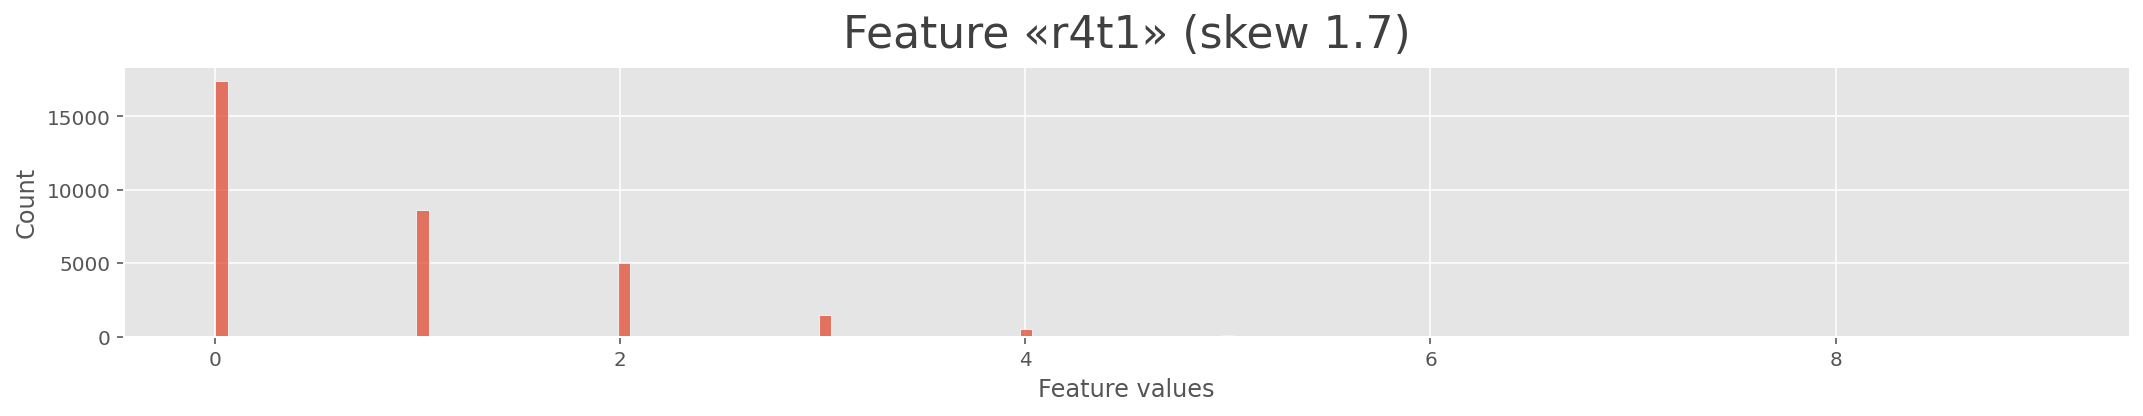

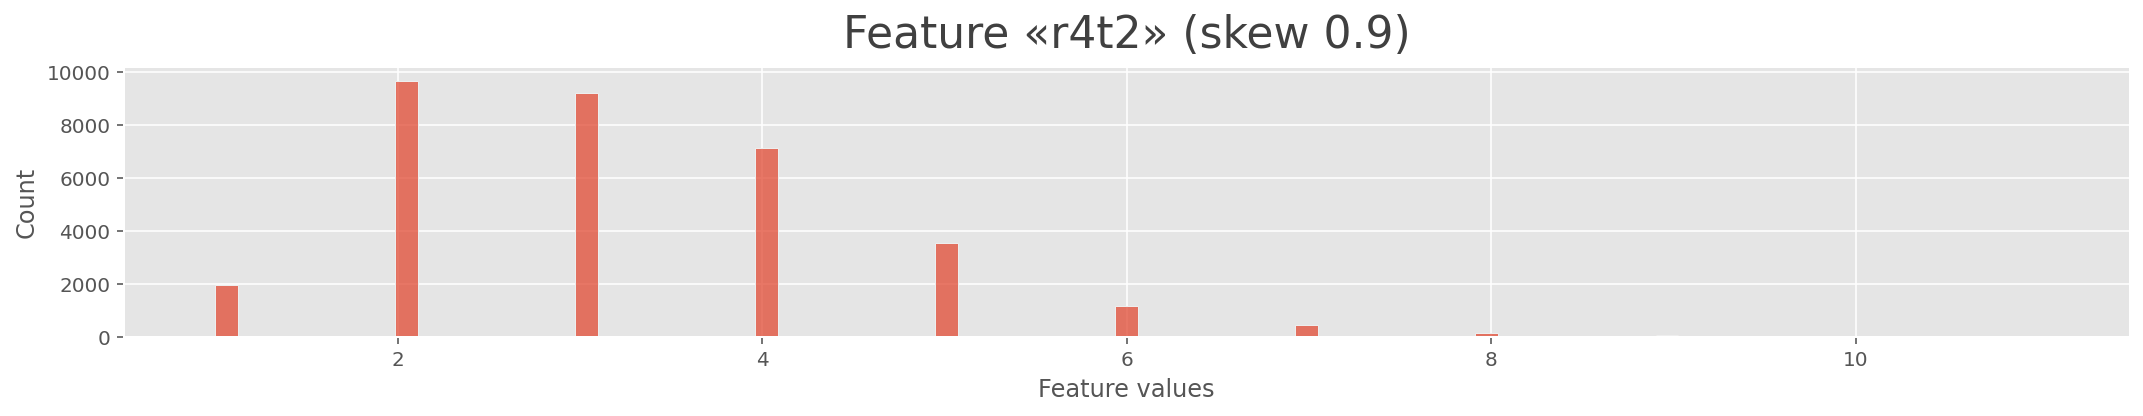

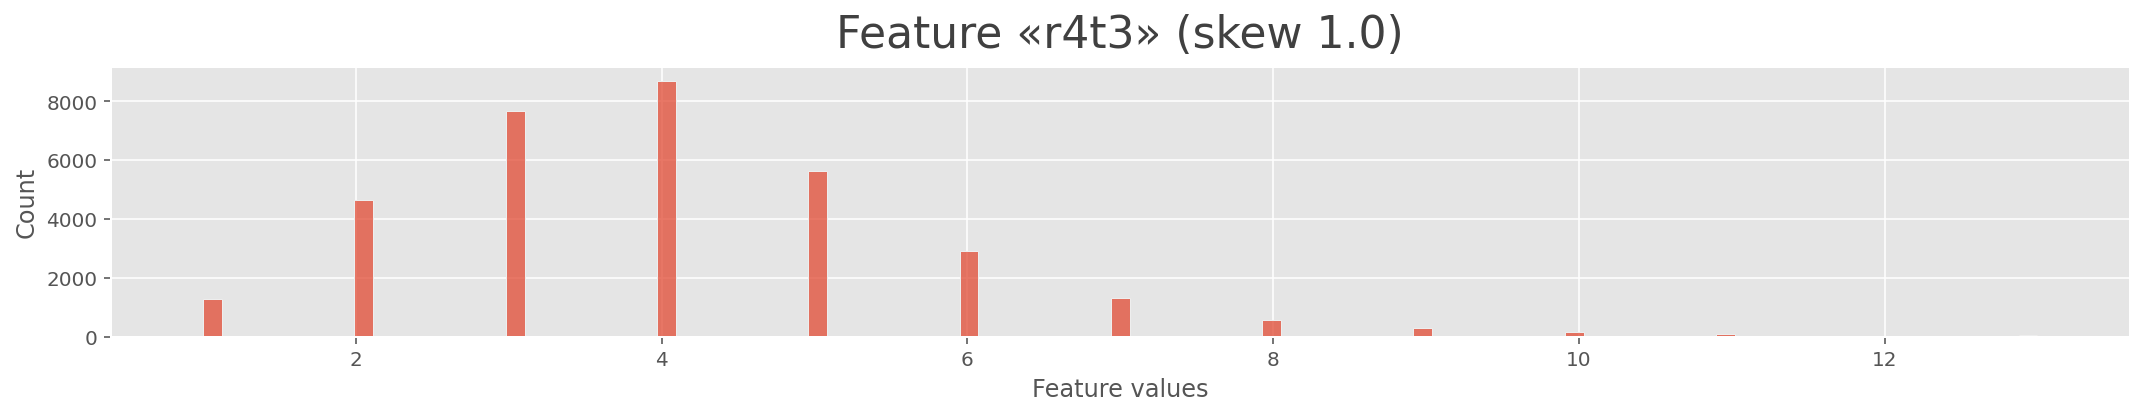

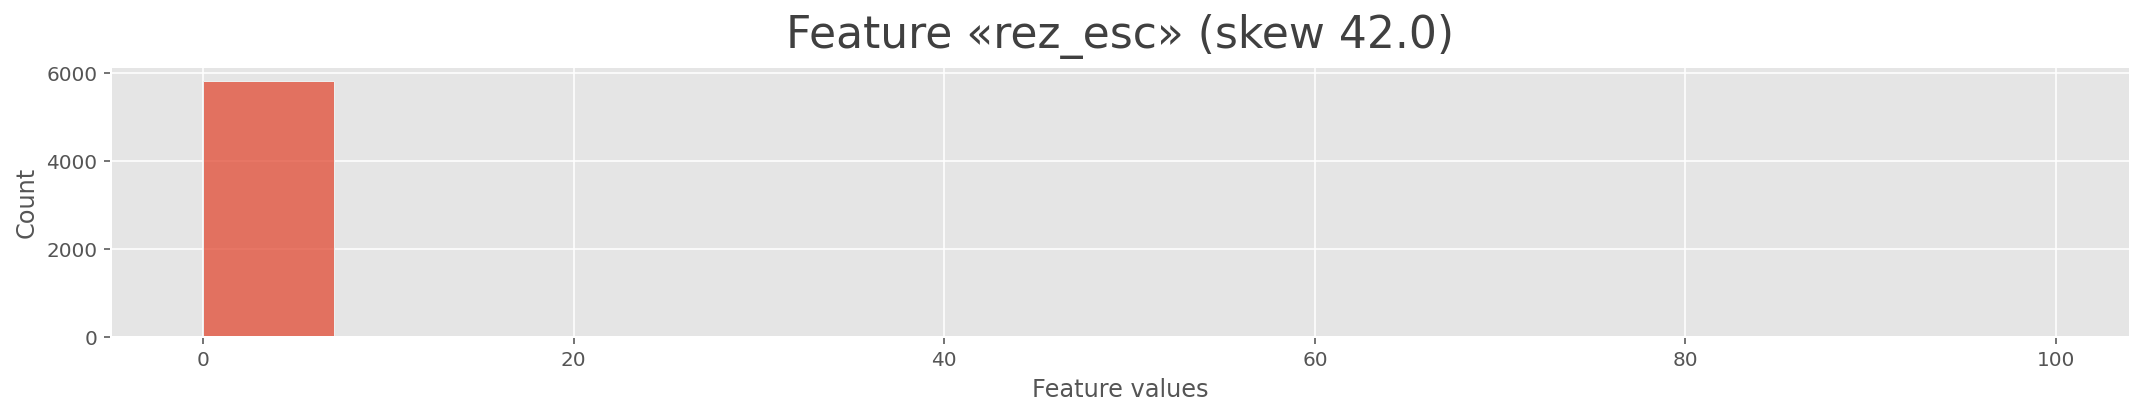

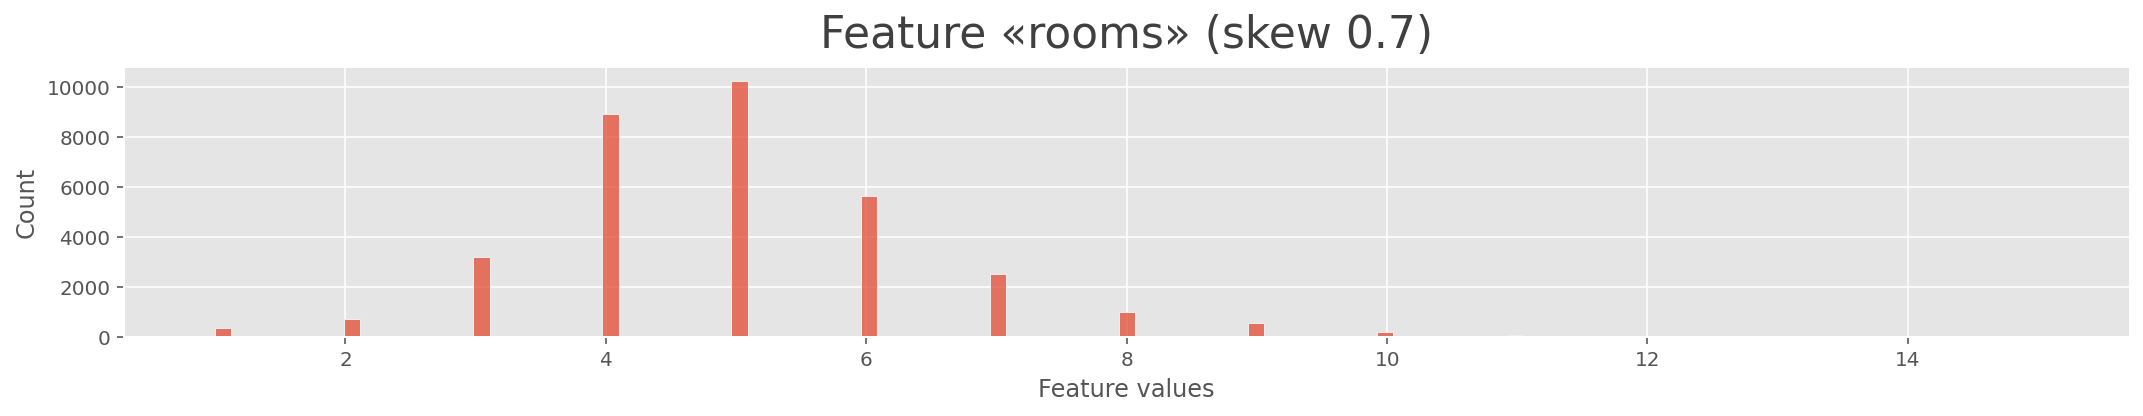

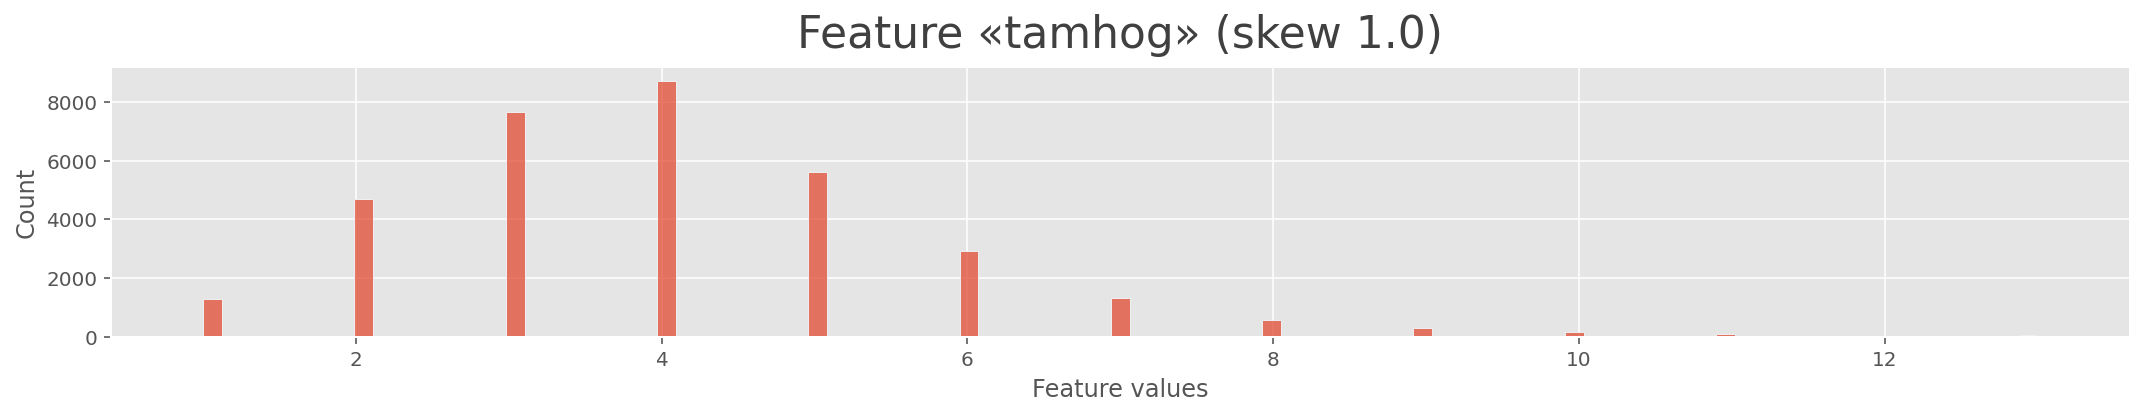

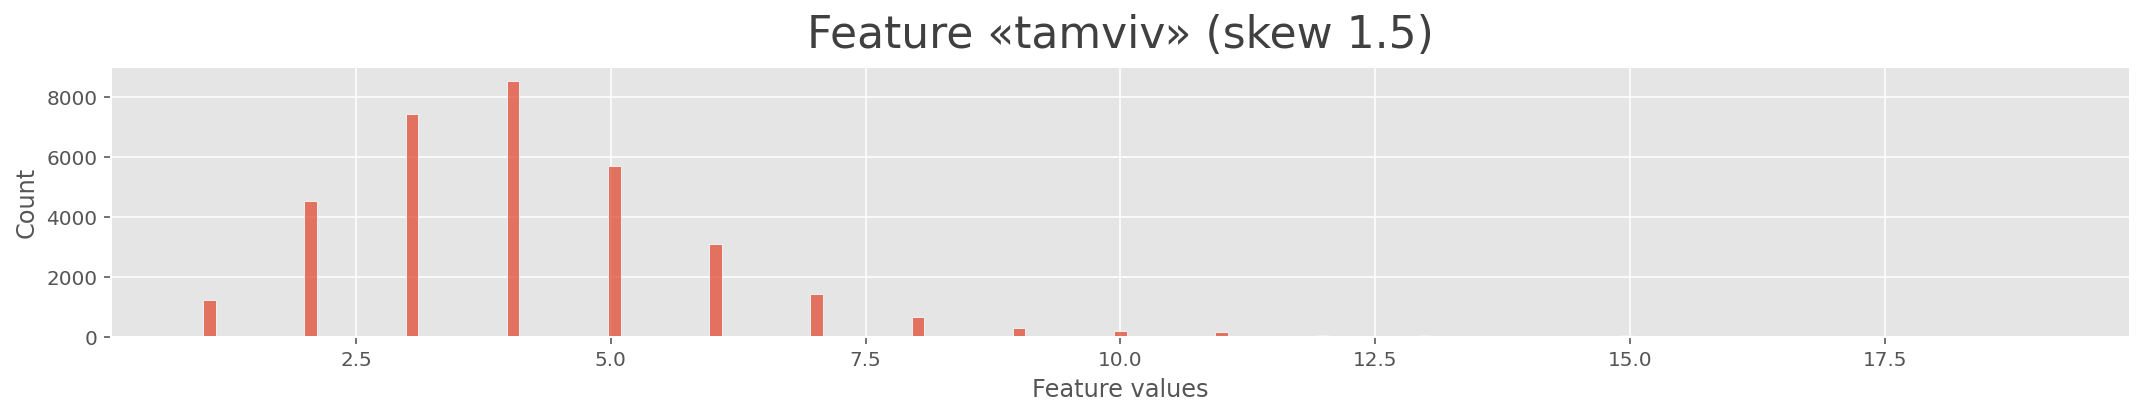

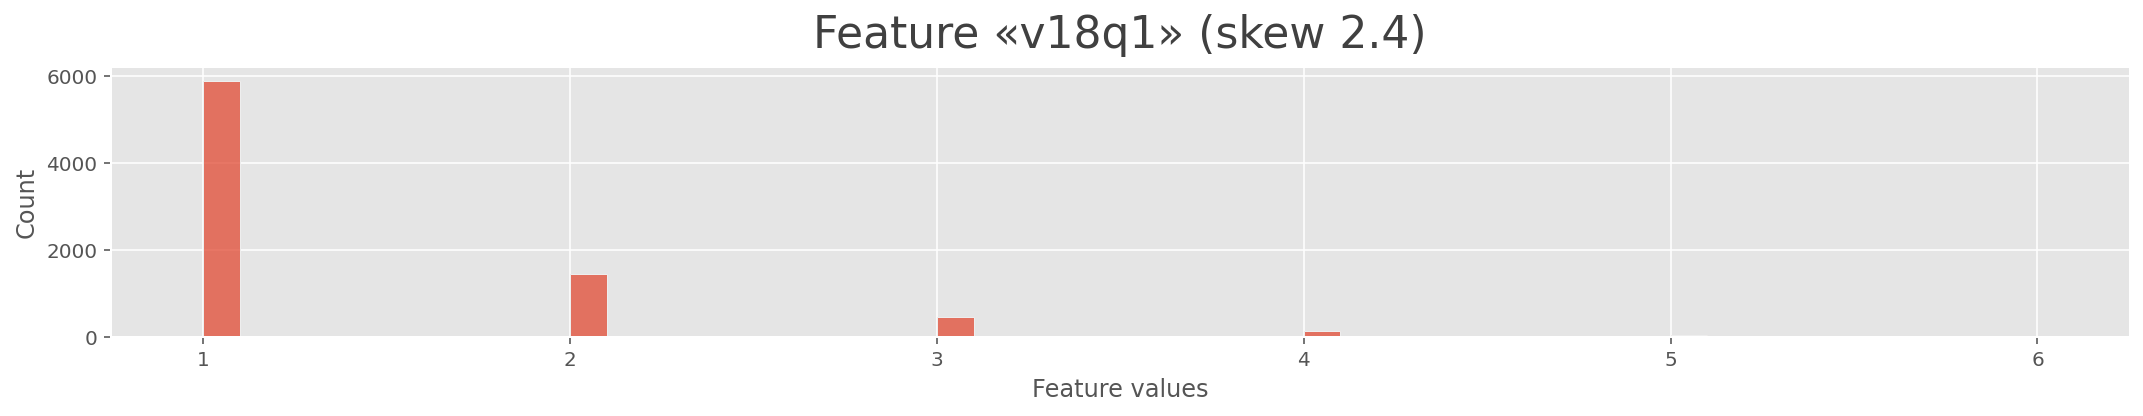

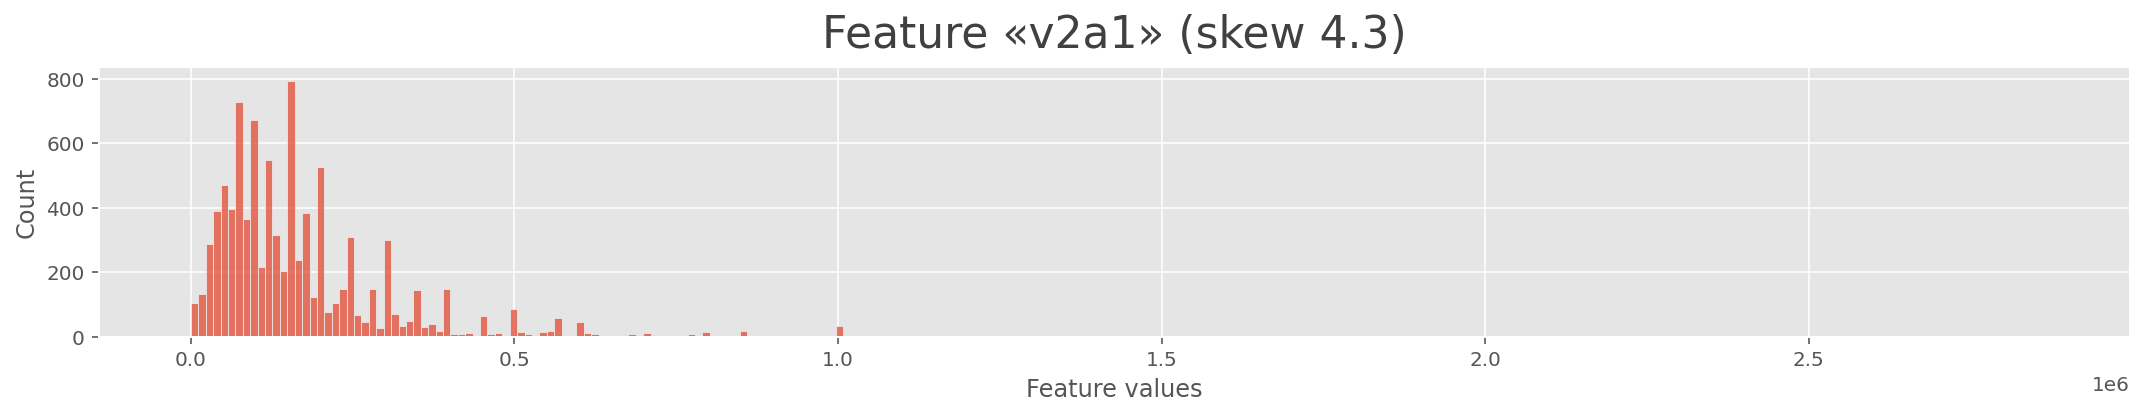

In [22]:
# Get numerical feature names from annotated codebook.
nums = cb[cb.cat!=1].name

for num in nums:
    sns.displot(data=df[num], height=3, aspect=5)
    if df[num].dtype != "object":
        skew_ = df[num].skew()
        plt.title(f"Feature «{num}» (skew {skew_:.1f})", size=TITLE_SIZE, pad=TITLE_PADDING)
    else: 
        plt.title(f"Feature «{num}»", size=TITLE_SIZE, pad=TITLE_PADDING)        
    plt.xlabel("Feature values")
    plt.tight_layout()
    plt.show()

## Outliers
- By measure of +/-3 times the IQR we do have some outliers in `overcrowding` and `tamviv`.

In [23]:
for num in ["age", "escolari", "meaneduc", "v2a1", "overcrowding", "tamviv"]:
    q25 = percentile(df[num], 25)
    q75 = percentile(df[num], 75)
    iqr = q75 - q25
    cut_off = iqr * 3

    lower_limit = q25 - cut_off
    upper_limit = q75 + cut_off

    outliers = [x for x in df[num] if x < lower_limit or x > upper_limit]
    print(f"{len(outliers)} outliers in «{num}»")

0 outliers in «age»
0 outliers in «escolari»
0 outliers in «meaneduc»
0 outliers in «v2a1»
233 outliers in «overcrowding»
189 outliers in «tamviv»


## Examining the target variable
**By visualizing the distribution of our target variable we see that the classes aren't distributed equally**.

Interestingly we have many data samples of «non vulnerable households» and much less samples of households in poverty. 

In [24]:
print("Value counts for target variable")
display(df_train.Target.value_counts().sort_index())

Value counts for target variable


1     755
2    1597
3    1209
4    5996
Name: Target, dtype: int64

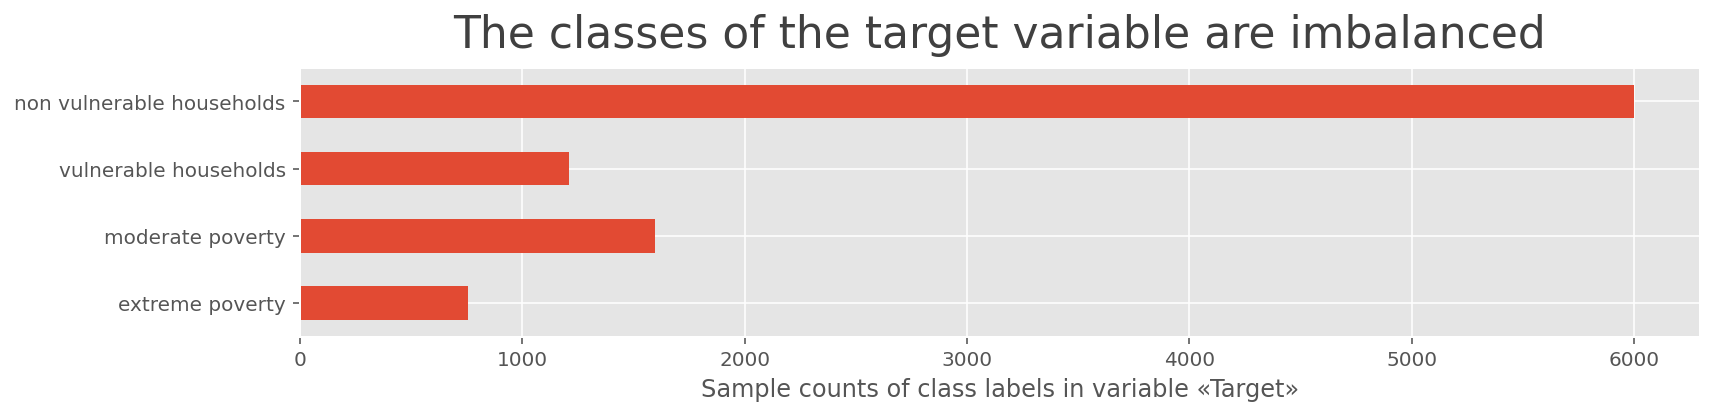

In [25]:
df_train.Target.value_counts().sort_index().plot.barh(figsize=(12,3))
plt.yticks(range(0, 4), labels=["extreme poverty", "moderate poverty", "vulnerable households", "non vulnerable households"])
plt.title("The classes of the target variable are imbalanced", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xlabel("Sample counts of class labels in variable «Target»")
plt.tight_layout()
plt.show()

Let's look at the target distribution when we aggregate by households. 

We have already seen above that there are households with more than one class label. I **remove the samples with duplicated qualifications** and **plot the class distribution of the target on household level and per head of household**.


We see that **the class imbalance is even more pronounced.**

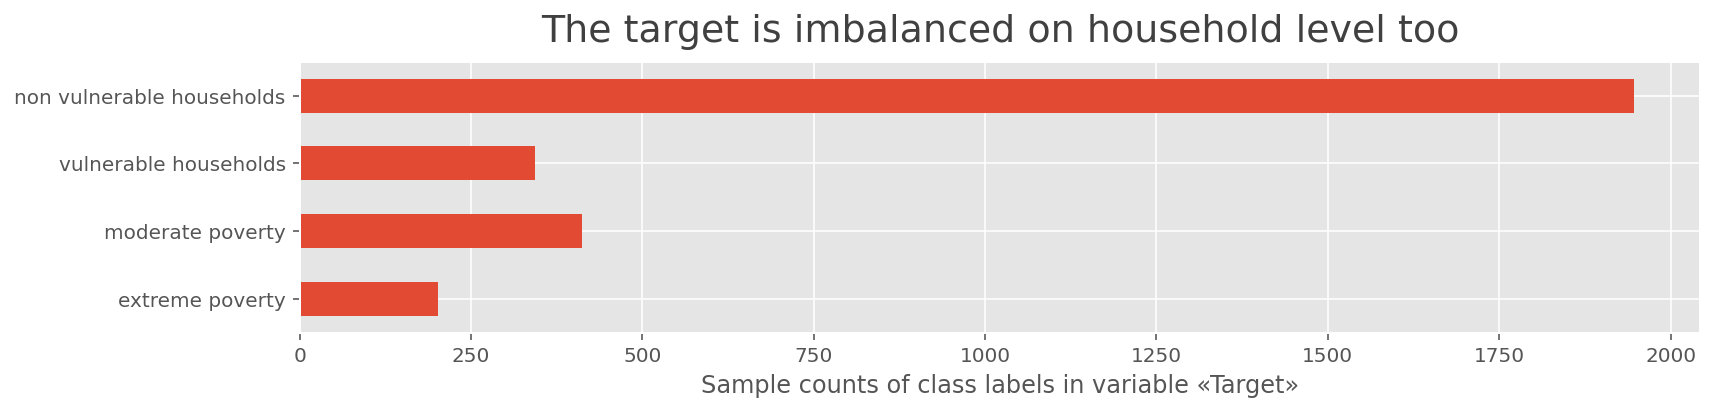

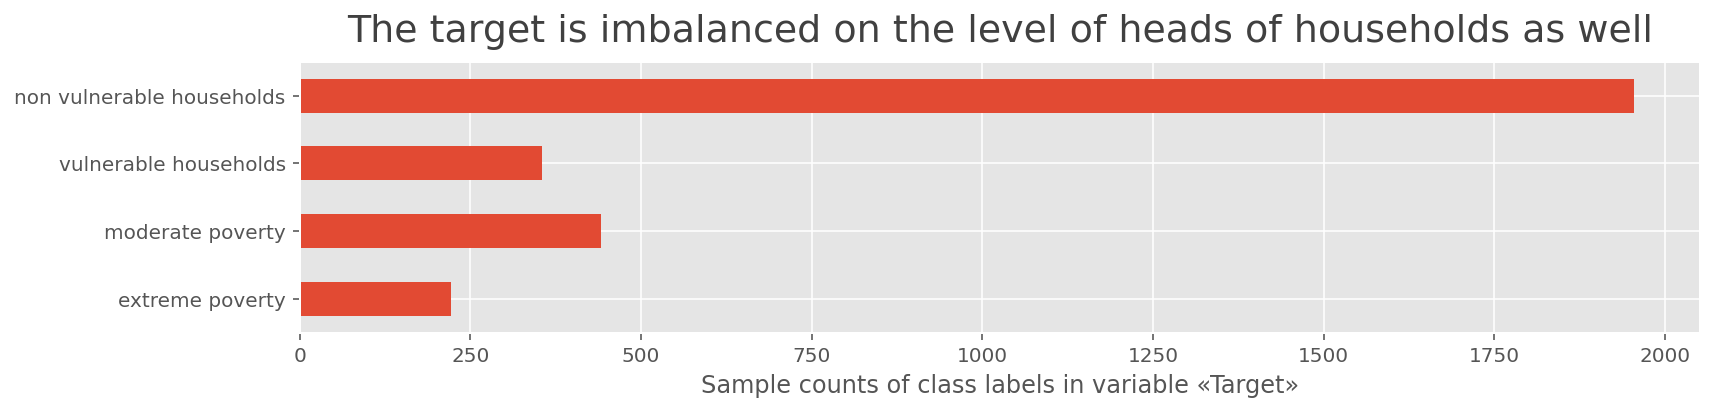

In [26]:
tmp = df_train.groupby("idhogar").Target.nunique()
# Keep only households with one class label
single_class = df_train[df_train.idhogar.isin(tmp[tmp==1].index)]
single_class = single_class.groupby("idhogar").head(1)

single_class.Target.value_counts().sort_index().plot.barh(figsize=(12,3))
plt.yticks(range(0, 4), labels=["extreme poverty", "moderate poverty", "vulnerable households", "non vulnerable households"])
plt.title("The target is imbalanced on household level too", size=TITLE_SIZE-3, pad=TITLE_PADDING)
plt.xlabel("Sample counts of class labels in variable «Target»")
plt.tight_layout()
plt.show()

df_train[df_train.parentesco1==True].Target.value_counts().sort_index().plot.barh(figsize=(12,3))
plt.yticks(range(0, 4), labels=["extreme poverty", "moderate poverty", "vulnerable households", "non vulnerable households"])
plt.title("The target is imbalanced on the level of heads of households as well", size=TITLE_SIZE-3, pad=TITLE_PADDING)
plt.xlabel("Sample counts of class labels in variable «Target»")
plt.tight_layout()
plt.show()

## Correlation of features

Calculating the correlation between the features and plotting a heatmap reveals:
- There aren't many strongly correlated features.
- Obviously the exact opposite features that we already identified stick out as perfectly correlated.

Admittedly the heatmap is hard to decipher with so many abbreviated variable names. So let's plot the correlation of all features in regard to the target variable.

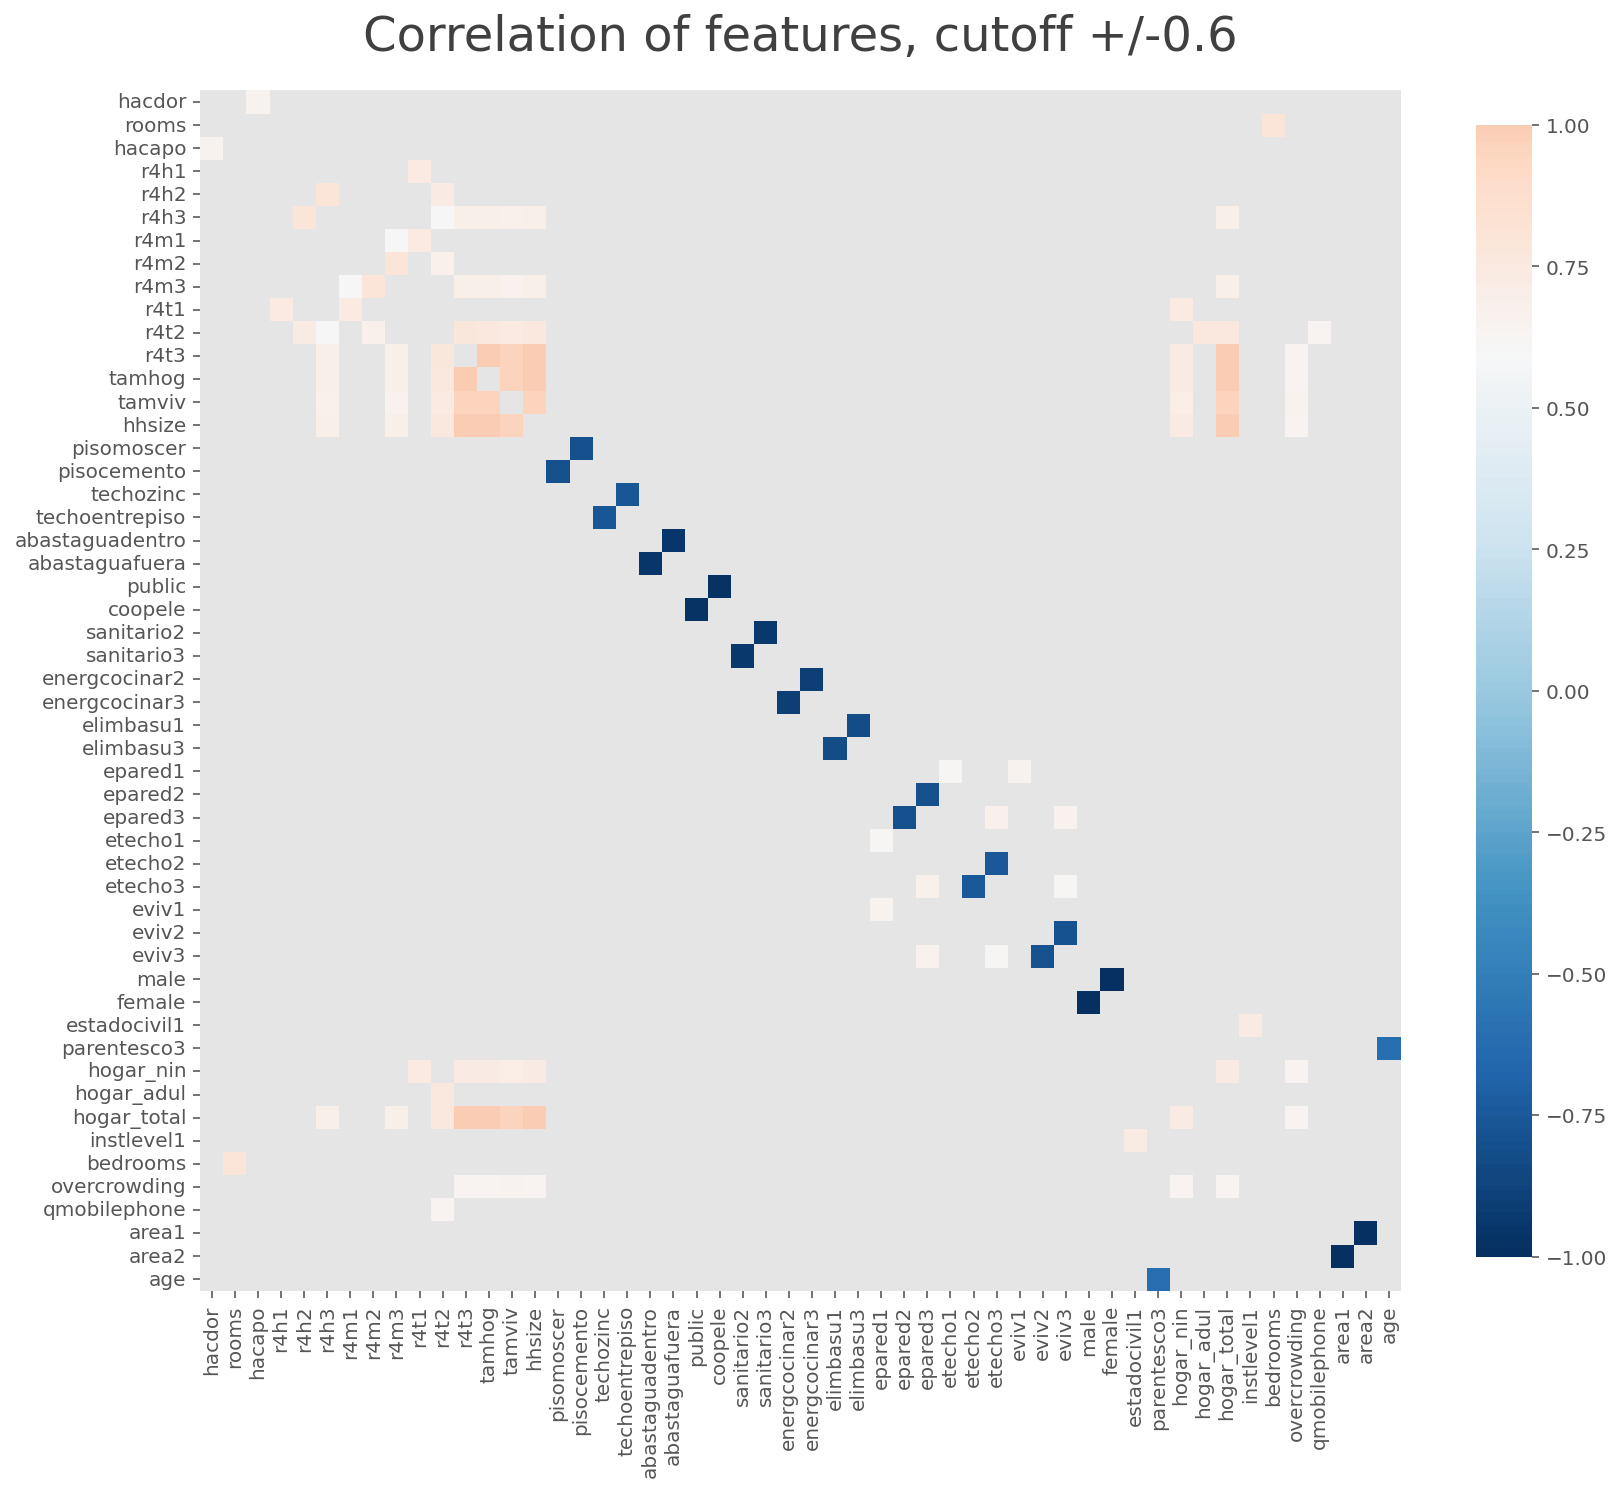

In [27]:
# Dropping elimbasu5 since it only contains 0 in the train data and therefore the correlation can't be computed
tmp = df_train.drop("elimbasu5", axis=1)
# dropping derivative features because these do not add additional information
tmp = tmp.drop(derivative_features, axis=1)

# The default method of Pearson's correlation assumes normally distributed continuous variables and linearity.  
# The target is ordinal and most of the features are too. Therefore I use Spearman's correlation.
corr = tmp.corr(method="spearman")
# Set threshold to keep only strong correlations.
correlation_treshold = 0.6

corr_cutoff = corr[(corr > correlation_treshold) | (corr < -correlation_treshold)]

np.fill_diagonal(corr_cutoff.values, np.nan)
corr_cutoff.dropna(how="all", inplace=True)
corr_cutoff.dropna(how="all", inplace=True, axis=1)

plt.figure(figsize=(12,12))
sns.heatmap(corr_cutoff, 
            cmap="RdBu_r", 
            # https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap
#             mask=np.triu(corr_cutoff),
            center=correlation_treshold,
            square=True, 
            annot=False, 
            xticklabels=1, 
            yticklabels=1,
            cbar_kws={"shrink": .7},
           )

plt.title(f"Correlation of features, cutoff +/-{correlation_treshold}", size=24, pad=20)
plt.tight_layout()
plt.show()

Plotting the correlations to the target show:
- **Only very few features have a more than weak correlation of +0.3 to the target.**
- `meaneduc` (*average years of education for adults*), `escolari`(*years of schooling*) and `v2a1` (*Monthly rent payment*) stick out as positively correlated. This makes sense. The more educated the adults are the more likely they can earn their living on their own. And the more you have to pay for rent the more you have to earn... 
- `cielorazo` (*house has ceiling*) as a positive correlated feature is comprehensible too. If you don't even have a roof you indeed are in deep trouble...
- `hogar_nin` (*Number of children 0 to 19 in household*) has a moderate negative correlation. This again makes sense – the more children are in a household the more difficult it will be to maintain an acceptable standard of living for all.

**Overall its interesting to see that the welfare workers probably collect many features that do not seem to have a substantial correlation to the resulting qualification for payments.** We can revisit this question when we calculate feature importances for the classifiers.

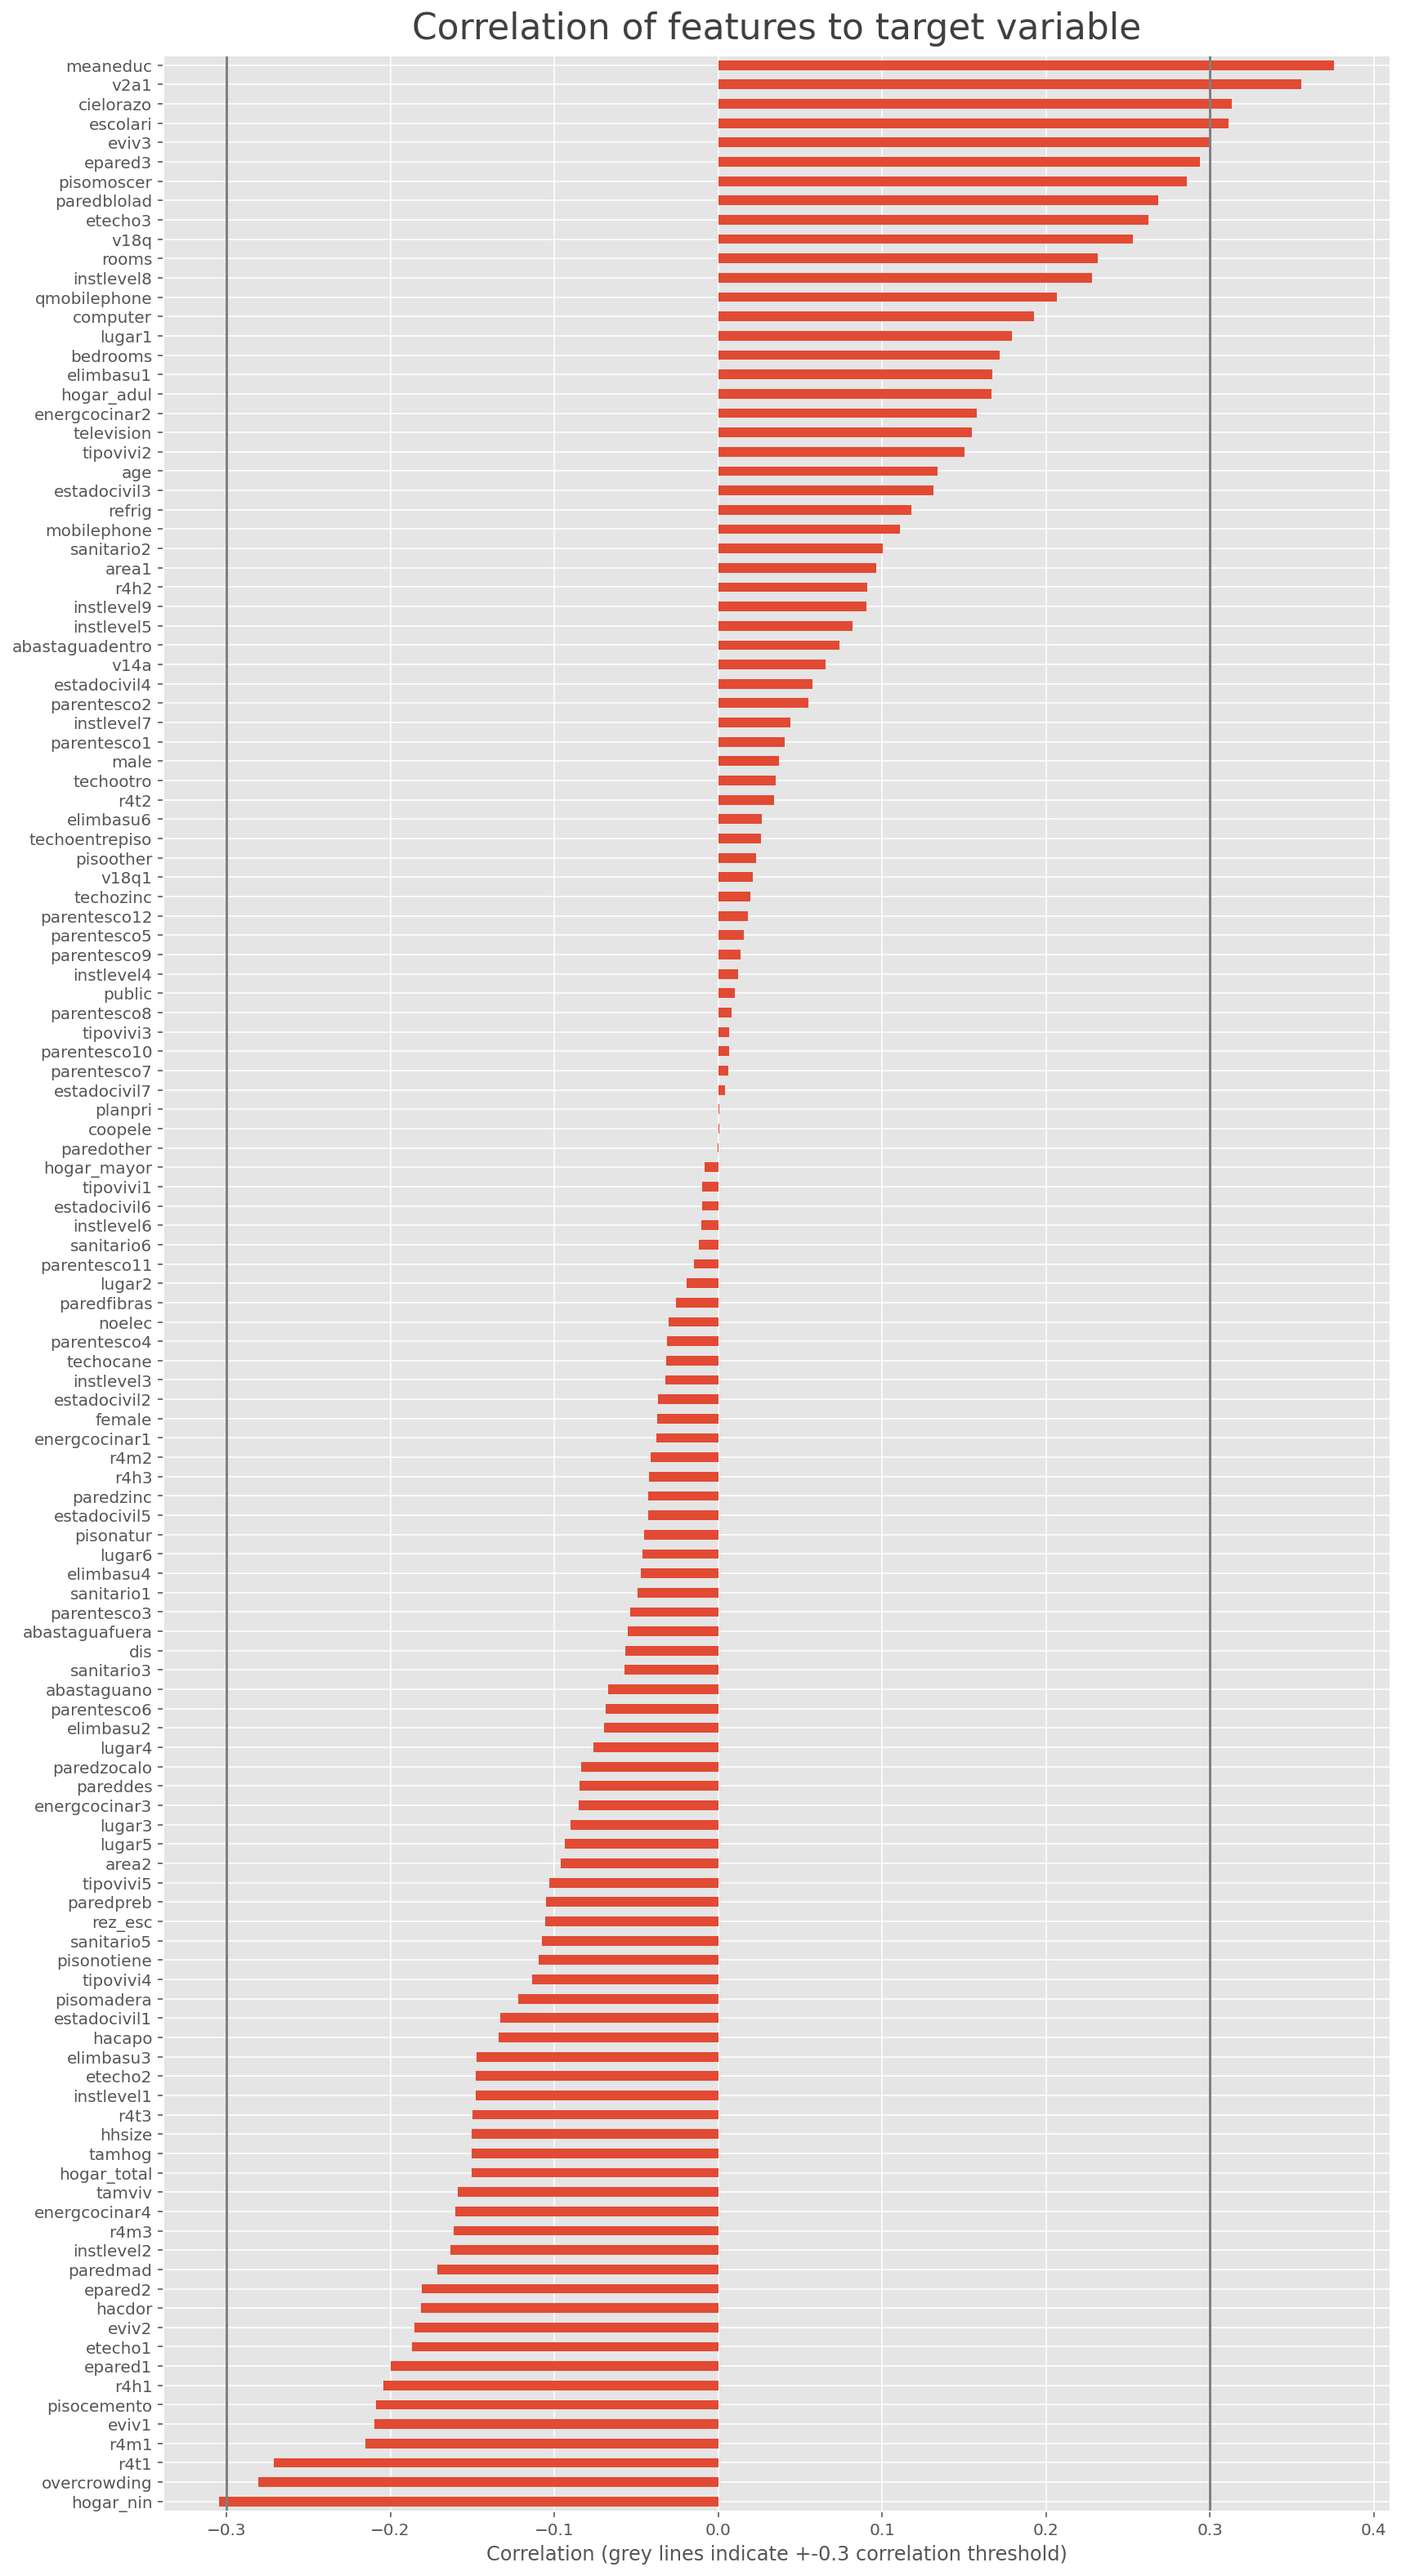

In [28]:
# Set threshold to keep only moderate to strong correlations.
correlation_treshold = 0.3

corr["Target"].drop("Target").sort_values(ascending=True)[:].plot.barh(figsize=(12,22))
plt.title(f"Correlation of features to target variable", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.axvline(-correlation_treshold, color="grey")
plt.axvline(correlation_treshold, color="grey")
plt.xlabel(f"Correlation (grey lines indicate +-{correlation_treshold} correlation threshold)")
plt.tight_layout()
plt.show()

## Comparison of train and test data

How similar is the training data to the test data set? If there were substantial differences it would make sense to take that into account when splitting a test set from train data to make the local score more representative.

- I try to make a comparison with dimensionality reduction. I use [umap-learn](https://umap-learn.readthedocs.io/en/latest/) to reduce the data to two dimensions and plot the test data vs. the training data. 
- **Overall the two data sets seem quite comparable.** I don't see any substantial differences that would call for special considerations when splitting a local test set.

In [29]:
# Quick data cleaning
df = pd.concat([df_train, df_test]).reset_index(drop=True)

# Remove redundant data
derivative_features = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 
                       'SQBmeaned', 'agesq', "female", "area2"]
df.drop(derivative_features, axis=1, inplace=True)

# Replace yes/no
cols = ["dependency", "edjefe", "edjefa"]
for col in cols:
    df[col].replace({"no":0}, inplace=True)
    df[col].replace({"yes":np.nan}, inplace=True)
    df[col] = df[col].astype(float)

# Separate labels to split the plots
tt_labels = np.where(df.Target.isna(), False, True)

# Fill NaNs
df.fillna(-99, inplace=True)

In [30]:
umapper = umap.UMAP(init="random")
umapped = umapper.fit_transform(df.drop(["Id", "idhogar", "Target"], axis=1))

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


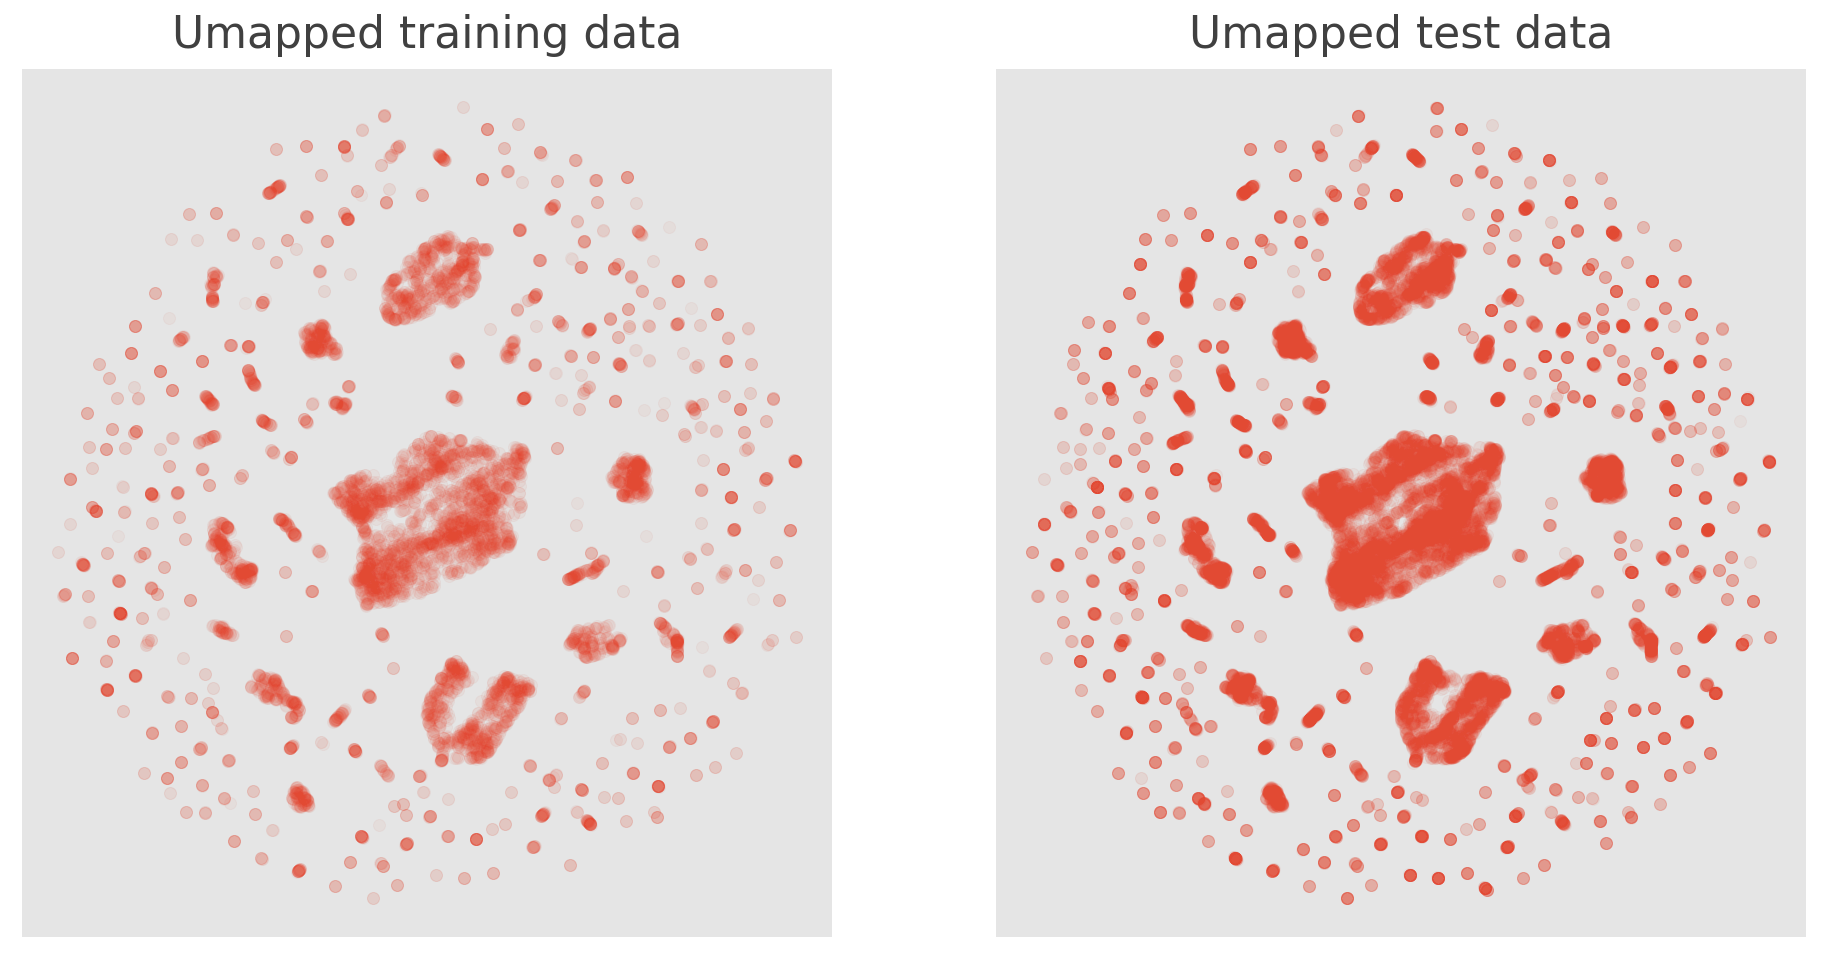

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(umapped[tt_labels, 0], umapped[tt_labels, 1], alpha=.05)
axs[0].set_title("Umapped training data", size=TITLE_SIZE, pad=TITLE_PADDING)
axs[1].scatter(umapped[np.invert(tt_labels), 0], umapped[np.invert(tt_labels), 1], alpha=.05)
axs[1].set_title("Umapped test data", size=TITLE_SIZE, pad=TITLE_PADDING)
for idx in range(0, 2):
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
plt.show()

# 3) Conclusions from EDA
---

## Key take-aways
- **The target is imbalanced** and we have to take this into account for training. 
- **We have to avoid data leakage during crossvalidation** because each sample contains shared information (the household features) and individual information.
- It seems sensible to try to aggregate/train/predict on the level of head of household. This would avoid mentioned data leakage.
- **We have more than double the amount of test data than training data. The test data is only useful if we submit entries on Kaggle.** Otherwise we have to work with the smaller train set. 
- If we wanted to improve our Kaggle scoring **we could try to use data leakage to our advantage** and include the test data in the preprocessing. However, the Kaggle organisators split the test set for scoring. Around one third counted towards the public leaderboard and the rest towards the private one and only the latter was relevant for the final standing in the competition. The split of the test data was unknown to the participants.

## Data cleaning and preparation
We need the following cleaning steps:
- Drop redundant derivative features.
- Drop redundant features `female` and `area2`.
- Fill missing values for `v2a1`, `v18q1`, `rez_esc`, `meaneduc`.
- Fill numerical values for `yes`/`no` in `edjefe`, `edjefa` and `dependency` and set data type to numerical.
- Impute the one erroneous value in `rez_esc`.
- Clean the samples of the 84 households that have two class labels and the one household that has 3.
- Remove households that have no head.
- Transform `v2a1` to more normal distribution.